<a href="https://colab.research.google.com/github/nawta/CHI_Rich_Subtitle/blob/main/Dynamik_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験段階

In [ ]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def load_json_files(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            with open(os.path.join(folder_path, filename), 'r') as f:
                data = json.load(f)
                all_data.extend(data)
    return pd.DataFrame(all_data)

def process_video_data(df):
    video_data = df[df['task'].isin(['video_questions', 'cnn_video_questions', 'nasa_tlx'])]
    video_stats = video_data.groupby(['condition', 'video_number']).agg({
        'readability': 'mean',
        'comprehension': 'mean',
        'engagement': 'mean',
        'num_correct': 'mean',
        'rt': 'mean',
        'mental_demand': 'mean',
        'physical_demand': 'mean',
        'temporal_demand': 'mean',
        'performance': 'mean',
        'effort': 'mean',
        'frustration': 'mean'
    }).reset_index()

    # 可視化
    metrics = ['readability', 'comprehension', 'engagement', 'num_correct', 'rt']
    fig, axes = plt.subplots(3, 2, figsize=(20, 30))
    for i, metric in enumerate(metrics):
        sns.barplot(x='video_number', y=metric, hue='condition', data=video_stats, ax=axes[i//2, i%2])
        axes[i//2, i%2].set_title(f'{metric} by Video and Condition')
    plt.tight_layout()
    plt.savefig('video_metrics.png')
    plt.close()

    # NASA-TLX可視化
    nasa_metrics = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    fig, ax = plt.subplots(figsize=(15, 8))
    video_stats.groupby('condition')[nasa_metrics].mean().plot(kind='bar', ax=ax)
    ax.set_title('Average NASA-TLX Scores by Condition')
    plt.tight_layout()
    plt.savefig('nasa_tlx.png')
    plt.close()

    return video_stats

def process_demographic_data(df):
    demo_data = df[df['task'] == 'demographic_survey']

    demographics = {
        'Gender': demo_data['response'].apply(lambda x: x['gender']).value_counts(),
        'Age': demo_data['response'].apply(lambda x: int(x['age'])),
        'Nationality': demo_data['response'].apply(lambda x: x['nationality']).value_counts(),
        'Native Language': demo_data['response'].apply(lambda x: x['native_language']).value_counts(),
        'Other Languages': demo_data['response'].apply(lambda x: x['other_languages'].split(',') if x['other_languages'] else []).explode().value_counts()
    }

    # 可視化
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    demographics['Gender'].plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%')
    axes[0, 0].set_title('Gender Distribution')
    demographics['Age'].plot(kind='hist', ax=axes[0, 1], bins=20)
    axes[0, 1].set_title('Age Distribution')
    demographics['Nationality'].plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Nationality Distribution')
    demographics['Native Language'].plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Native Language Distribution')
    plt.tight_layout()
    plt.savefig('demographics.png')
    plt.close()

    return demographics

def process_overall_stats(df):
    total_time = df.groupby('subject_id')['rt'].sum()
    correct_answers = df[df['task'] == 'cnn_video_questions'].groupby('subject_id')['num_correct'].sum()
    total_questions = df[df['task'] == 'cnn_video_questions'].groupby('subject_id').size() * 7  # Assuming 7 questions per video
    accuracy_range = (correct_answers / total_questions).agg(['min', 'max'])

    consent_count = df[df['task'] == 'consent']['response'].value_counts()[0]
    dummy_fail_count = df[(df['task'].isin(['video_questions', 'nasa_tlx'])) & (df['has_dummy'] == True) & (df['dummy_correct'] == False)].groupby('subject_id').size().sum()
    high_accuracy_count = ((correct_answers / total_questions) >= 0.8).sum()
    low_accuracy_count = ((correct_answers / total_questions) < 0.8).sum()

    total_participants = df['subject_id'].nunique()

    overall_stats = {
        'Total Time (mean)': total_time.mean(),
        'Total Time (std)': total_time.std(),
        'Accuracy Range': accuracy_range,
        'Consent Count': consent_count,
        'Consent Percentage': consent_count / total_participants * 100,
        'Dummy Fail Count': dummy_fail_count,
        'Dummy Fail Percentage': dummy_fail_count / total_participants * 100,
        'High Accuracy Count': high_accuracy_count,
        'High Accuracy Percentage': high_accuracy_count / total_participants * 100,
        'Low Accuracy Count': low_accuracy_count,
        'Low Accuracy Percentage': low_accuracy_count / total_participants * 100
    }

    return overall_stats

def process_feedback(df):
    return df[df['task'] == 'final_feedback']['response'].apply(lambda x: x['Q0']).tolist()

# メイン処理
folder_path = '/content/drive/MyDrive/山下先生ネタ/json'  # JSONファイルが格納されているフォルダのパスを指定
df = load_json_files(folder_path)

video_stats = process_video_data(df)
demographics = process_demographic_data(df)
overall_stats = process_overall_stats(df)
feedback = process_feedback(df)

# 結果の出力
print("Video Statistics:")
print(video_stats)
print("\nDemographics:")
print(demographics)
print("\nOverall Statistics:")
print(overall_stats)
print("\nFeedback:")
print(feedback)

# 結果をCSVファイルに保存
video_stats.to_csv('video_statistics.csv', index=False)
pd.DataFrame(demographics).to_csv('demographics.csv')
pd.DataFrame([overall_stats]).to_csv('overall_statistics.csv', index=False)
pd.DataFrame(feedback, columns=['Feedback']).to_csv('feedback.csv', index=False)

KeyError: "Column(s) ['comprehension', 'effort', 'engagement', 'frustration', 'mental_demand', 'performance', 'physical_demand', 'readability', 'temporal_demand'] do not exist"

Loaded data shape: (75, 22)
Columns: Index(['trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'subject_id', 'PROLIFIC_PID', 'STUDY_ID', 'SESSION_ID', 'paramsPresent',
       'rt', 'stimulus', 'response', 'task', 'user_selections', 'correct',
       'num_correct', 'condition', 'video_number', 'question_order',
       'has_dummy', 'dummy_correct', 'correct_answers'],
      dtype='object')
Processing video data...
Video data shape: (38, 22)
Video data columns: Index(['trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'subject_id', 'PROLIFIC_PID', 'STUDY_ID', 'SESSION_ID', 'paramsPresent',
       'rt', 'stimulus', 'response', 'task', 'user_selections', 'correct',
       'num_correct', 'condition', 'video_number', 'question_order',
       'has_dummy', 'dummy_correct', 'correct_answers'],
      dtype='object')
Video stats shape: (11, 13)
Video stats columns: Index(['condition', 'video_number', 'readability', 'comprehension',
       'engagement', 'nu

<ipython-input-4-7dea7c02be5f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_data[col] = video_data['response'].apply(lambda x: x.get(col) if isinstance(x, dict) else None)
<ipython-input-4-7dea7c02be5f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_data[col] = video_data['response'].apply(lambda x: x.get(col) if isinstance(x, dict) else None)
<ipython-input-4-7dea7c02be5f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Processing demographic data...
Demographic data shape: (3, 22)


AttributeError: 'Index' object has no attribute 'plot'

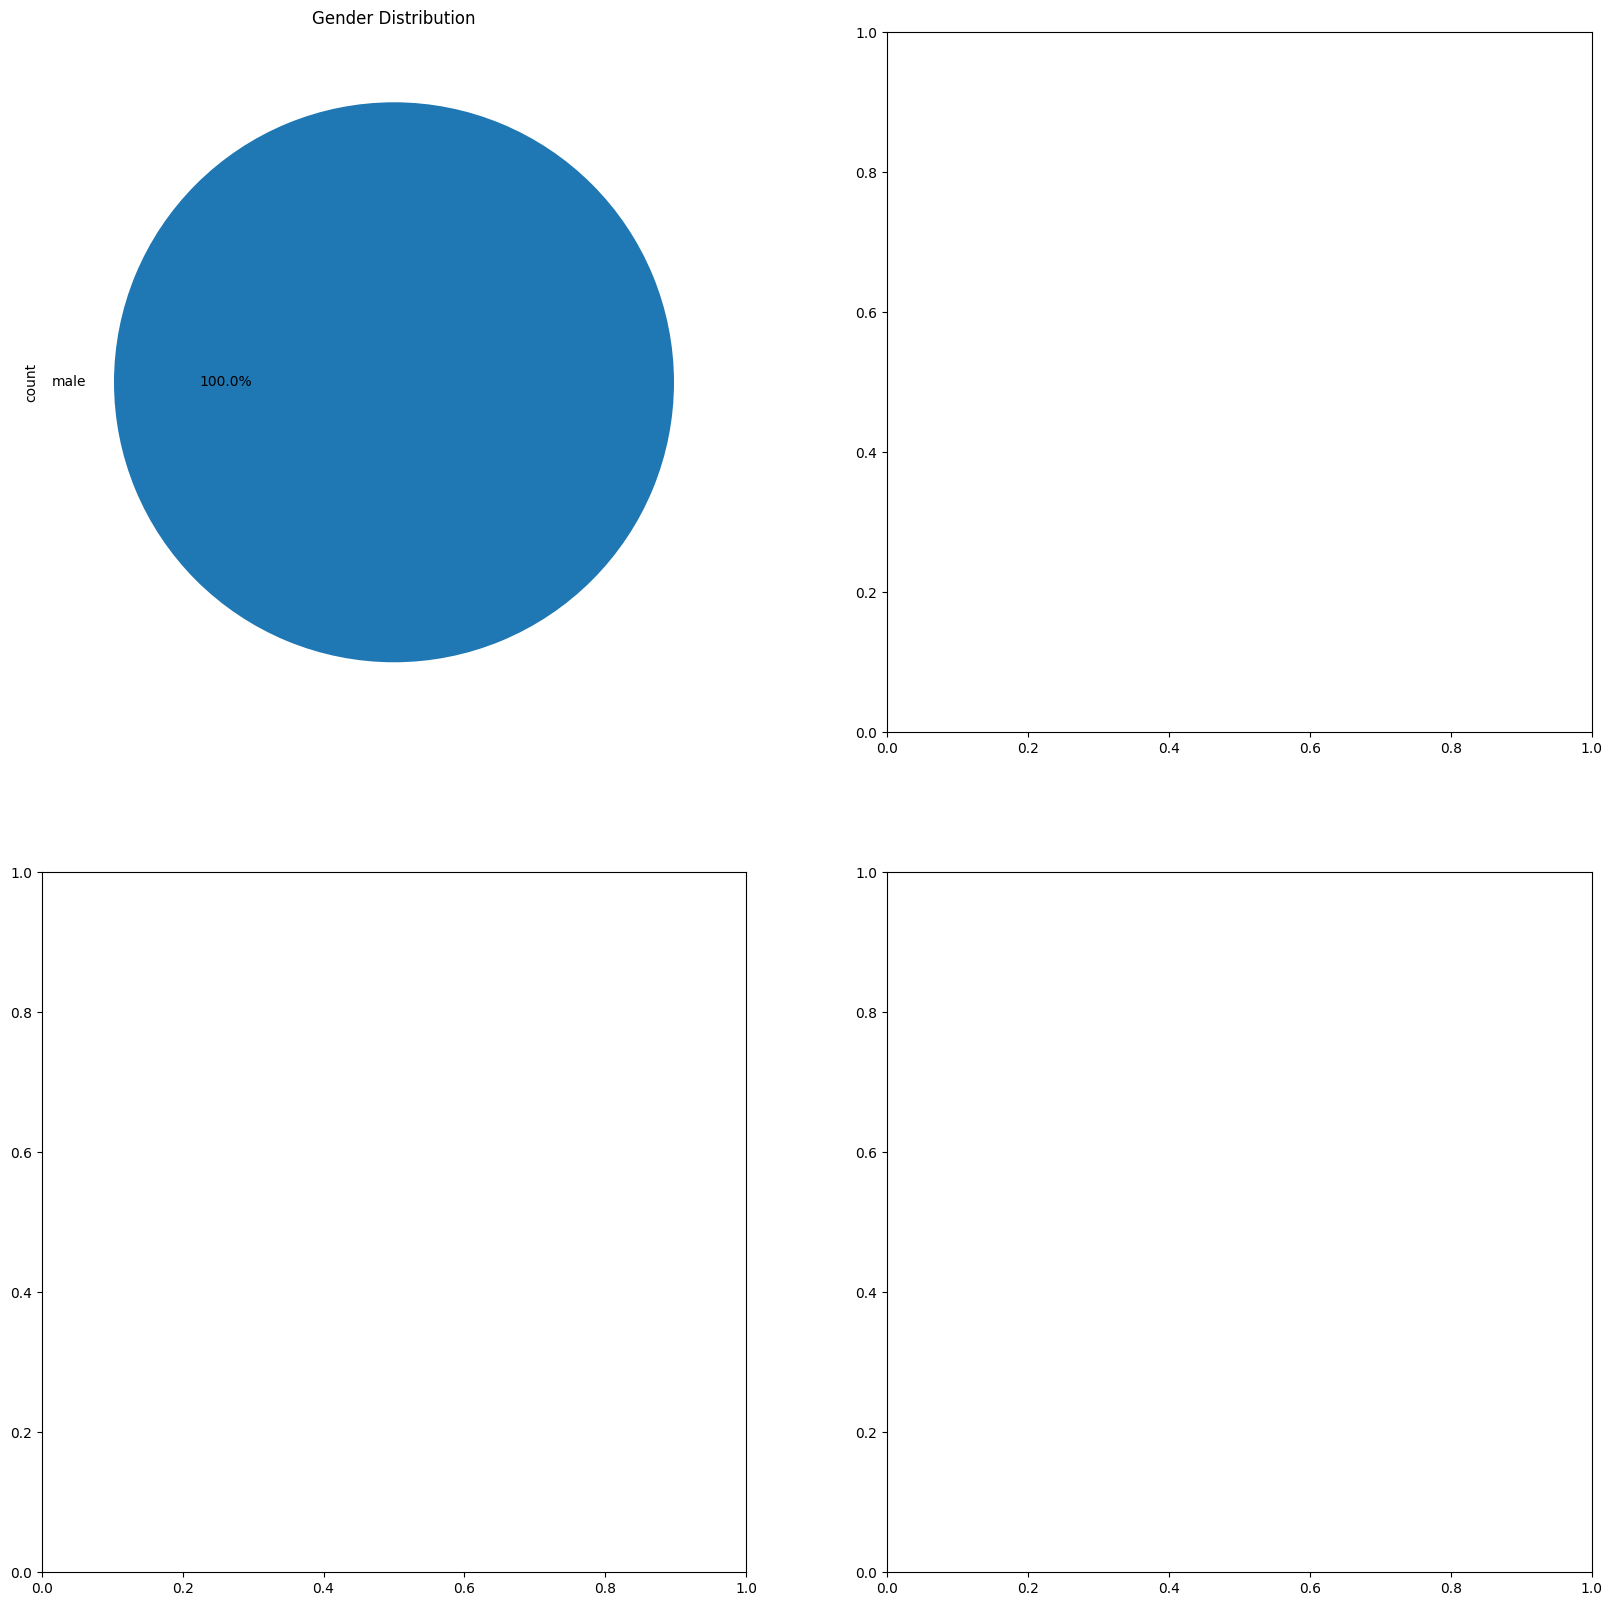

In [ ]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def load_json_files(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            with open(os.path.join(folder_path, filename), 'r') as f:
                data = json.load(f)
                all_data.extend(data)
    df = pd.DataFrame(all_data)
    print("Loaded data shape:", df.shape)
    print("Columns:", df.columns)
    return df

def process_video_data(df):
    print("Processing video data...")
    video_data = df[df['task'].isin(['video_questions', 'cnn_video_questions', 'nasa_tlx'])]
    print("Video data shape:", video_data.shape)
    print("Video data columns:", video_data.columns)

    # response列から必要なデータを抽出
    for col in ['readability', 'comprehension', 'engagement', 'mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']:
        video_data[col] = video_data['response'].apply(lambda x: x.get(col) if isinstance(x, dict) else None)

    # 集計関数を定義
    def safe_mean(x):
        return x.mean() if len(x) > 0 else None

    # 各カラムの存在をチェックし、存在する場合のみ集計を行う
    agg_dict = {}
    for col in ['readability', 'comprehension', 'engagement', 'num_correct', 'rt',
                'mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']:
        if col in video_data.columns:
            agg_dict[col] = safe_mean
        else:
            print(f"Warning: Column '{col}' not found in video data")

    video_stats = video_data.groupby(['condition', 'video_number']).agg(agg_dict).reset_index()

    print("Video stats shape:", video_stats.shape)
    print("Video stats columns:", video_stats.columns)

    # 可視化
    metrics = [col for col in ['readability', 'comprehension', 'engagement', 'num_correct', 'rt'] if col in video_stats.columns]
    fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 10*len(metrics)))
    for i, metric in enumerate(metrics):
        sns.barplot(x='video_number', y=metric, hue='condition', data=video_stats, ax=axes[i] if len(metrics) > 1 else axes)
        (axes[i] if len(metrics) > 1 else axes).set_title(f'{metric} by Video and Condition')
    plt.tight_layout()
    plt.savefig('video_metrics.png')
    plt.close()

    # NASA-TLX可視化
    nasa_metrics = [col for col in ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration'] if col in video_stats.columns]
    if nasa_metrics:
        fig, ax = plt.subplots(figsize=(15, 8))
        video_stats.groupby('condition')[nasa_metrics].mean().plot(kind='bar', ax=ax)
        ax.set_title('Average NASA-TLX Scores by Condition')
        plt.tight_layout()
        plt.savefig('nasa_tlx.png')
        plt.close()
    else:
        print("Warning: No NASA-TLX metrics found in the data")

    return video_stats

def process_demographic_data(df):
    print("Processing demographic data...")
    demo_data = df[df['task'] == 'demographic_survey']
    print("Demographic data shape:", demo_data.shape)

    demographics = {}
    for field in ['gender', 'age', 'nationality', 'native_language', 'other_languages']:
        values = demo_data['response'].apply(lambda x: x.get(field) if isinstance(x, dict) else None)
        if not values.isna().all():
            demographics[field.capitalize()] = values.value_counts()
        else:
            print(f"Warning: '{field}' not found in demographic responses")

    # Age needs special handling as it should be numeric
    if 'Age' in demographics:
        demographics['Age'] = pd.to_numeric(demographics['Age'].index, errors='coerce')

    # 可視化
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    for i, (key, value) in enumerate(demographics.items()):
        if i < 4:  # Only plot the first 4 demographics
            if key == 'Age':
                value.plot(kind='hist', ax=axes[i//2, i%2], bins=20)
            else:
                value.plot(kind='pie', ax=axes[i//2, i%2], autopct='%1.1f%%')
            axes[i//2, i%2].set_title(f'{key} Distribution')
    plt.tight_layout()
    plt.savefig('demographics.png')
    plt.close()

    return demographics

# 他の関数も同様に修正...

# メイン処理
folder_path = '/content/drive/MyDrive/山下先生ネタ/json'  # JSONファイルが格納されているフォルダのパスを指定
df = load_json_files(folder_path)

video_stats = process_video_data(df)
demographics = process_demographic_data(df)
overall_stats = process_overall_stats(df)
feedback = process_feedback(df)

# 結果の出力
print("Video Statistics:")
print(video_stats)
print("\nDemographics:")
print(demographics)
print("\nOverall Statistics:")
print(overall_stats)
print("\nFeedback:")
print(feedback)

# 結果をCSVファイルに保存
video_stats.to_csv('video_statistics.csv', index=False)
pd.DataFrame(demographics).to_csv('demographics.csv')
pd.DataFrame([overall_stats]).to_csv('overall_statistics.csv', index=False)
pd.DataFrame(feedback, columns=['Feedback']).to_csv('feedback.csv', index=False)

In [ ]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def load_json_files(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            with open(os.path.join(folder_path, filename), 'r') as f:
                data = json.load(f)
                all_data.extend(data)
    df = pd.DataFrame(all_data)
    print("Loaded data shape:", df.shape)
    print("Columns:", df.columns)
    return df

def process_video_data(df):
    print("Processing video data...")
    video_data = df[df['task'].isin(['video_questions', 'cnn_video_questions', 'nasa_tlx'])].copy()
    print("Video data shape:", video_data.shape)
    print("Video data columns:", video_data.columns)

    # response列から必要なデータを抽出
    for col in ['readability', 'comprehension', 'engagement', 'mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']:
        video_data[col] = video_data['response'].apply(lambda x: x.get(col) if isinstance(x, dict) else None)

    print("Columns after extraction:", video_data.columns)
    print("Sample of extracted data:")
    print(video_data[['readability', 'comprehension', 'engagement', 'mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']].head())

    # 集計関数を定義
    def safe_mean(x):
        return x.mean() if len(x) > 0 else None

    # 各カラムの存在をチェックし、存在する場合のみ集計を行う
    agg_dict = {}
    for col in ['readability', 'comprehension', 'engagement', 'num_correct', 'rt',
                'mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']:
        if col in video_data.columns:
            agg_dict[col] = safe_mean
        else:
            print(f"Warning: Column '{col}' not found in video data")

    video_stats = video_data.groupby(['condition', 'video_number']).agg(agg_dict).reset_index()

    print("Video stats shape:", video_stats.shape)
    print("Video stats columns:", video_stats.columns)
    print("Sample of video stats:")
    print(video_stats.head())

    # 可視化
    metrics = [col for col in ['readability', 'comprehension', 'engagement', 'num_correct', 'rt'] if col in video_stats.columns]
    fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 10*len(metrics)))
    axes = [axes] if len(metrics) == 1 else axes
    for i, metric in enumerate(metrics):
        sns.barplot(x='video_number', y=metric, hue='condition', data=video_stats, ax=axes[i])
        axes[i].set_title(f'{metric} by Video and Condition')
    plt.tight_layout()
    plt.savefig('video_metrics.png')
    plt.close()

    # NASA-TLX可視化
    nasa_metrics = [col for col in ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration'] if col in video_stats.columns]
    if nasa_metrics:
        fig, ax = plt.subplots(figsize=(15, 8))
        video_stats.groupby('condition')[nasa_metrics].mean().plot(kind='bar', ax=ax)
        ax.set_title('Average NASA-TLX Scores by Condition')
        plt.tight_layout()
        plt.savefig('nasa_tlx.png')
        plt.close()
    else:
        print("Warning: No NASA-TLX metrics found in the data")

    return video_stats

def process_demographic_data(df):
    print("Processing demographic data...")
    demo_data = df[df['task'] == 'demographic_survey']
    print("Demographic data shape:", demo_data.shape)
    print("Sample of demographic data:")
    print(demo_data['response'].head())

    demographics = {}
    for field in ['gender', 'age', 'nationality', 'native_language', 'other_languages']:
        values = demo_data['response'].apply(lambda x: x.get(field) if isinstance(x, dict) else None)
        if not values.isna().all():
            demographics[field.capitalize()] = values.value_counts()
            print(f"{field.capitalize()} data:")
            print(demographics[field.capitalize()])
        else:
            print(f"Warning: '{field}' not found in demographic responses")

    # Age needs special handling as it should be numeric
    if 'Age' in demographics:
        demographics['Age'] = pd.to_numeric(demographics['Age'], errors='coerce')
        print("Age data after conversion:")
        print(demographics['Age'])

    # 可視化
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    for i, (key, value) in enumerate(demographics.items()):
        if i < 4:  # Only plot the first 4 demographics
            if key == 'Age':
                value.plot(kind='hist', ax=axes[i//2, i%2], bins=20)
            elif isinstance(value, pd.Series):
                value.plot(kind='pie', ax=axes[i//2, i%2], autopct='%1.1f%%')
            else:
                print(f"Warning: Unable to plot {key} data")
            axes[i//2, i%2].set_title(f'{key} Distribution')
    plt.tight_layout()
    plt.savefig('demographics.png')
    plt.close()

    return demographics

def process_overall_stats(df):
    print("Processing overall statistics...")
    total_time = df.groupby('subject_id')['rt'].sum()
    correct_answers = df[df['task'] == 'cnn_video_questions'].groupby('subject_id')['num_correct'].sum()
    total_questions = df[df['task'] == 'cnn_video_questions'].groupby('subject_id').size() * 7  # Assuming 7 questions per video
    accuracy_range = (correct_answers / total_questions).agg(['min', 'max'])

    consent_count = df[df['task'] == 'consent']['response'].value_counts()[0]
    dummy_fail_count = df[(df['task'].isin(['video_questions', 'nasa_tlx'])) & (df['has_dummy'] == True) & (df['dummy_correct'] == False)].groupby('subject_id').size().sum()
    high_accuracy_count = ((correct_answers / total_questions) >= 0.8).sum()
    low_accuracy_count = ((correct_answers / total_questions) < 0.8).sum()

    total_participants = df['subject_id'].nunique()

    overall_stats = {
        'Total Time (mean)': total_time.mean(),
        'Total Time (std)': total_time.std(),
        'Accuracy Range': accuracy_range,
        'Consent Count': consent_count,
        'Consent Percentage': consent_count / total_participants * 100,
        'Dummy Fail Count': dummy_fail_count,
        'Dummy Fail Percentage': dummy_fail_count / total_participants * 100,
        'High Accuracy Count': high_accuracy_count,
        'High Accuracy Percentage': high_accuracy_count / total_participants * 100,
        'Low Accuracy Count': low_accuracy_count,
        'Low Accuracy Percentage': low_accuracy_count / total_participants * 100
    }

    print("Overall statistics:")
    for key, value in overall_stats.items():
        print(f"{key}: {value}")

    return overall_stats

def process_feedback(df):
    print("Processing feedback...")
    feedback = df[df['task'] == 'final_feedback']['response'].apply(lambda x: x.get('Q0') if isinstance(x, dict) else None).tolist()
    print("Feedback responses:")
    for i, f in enumerate(feedback):
        print(f"Feedback {i+1}: {f}")
    return feedback

# メイン処理
folder_path = '/content/drive/MyDrive/山下先生ネタ/json'  # JSONファイルが格納されているフォルダのパスを指定
df = load_json_files(folder_path)

video_stats = process_video_data(df)
demographics = process_demographic_data(df)
overall_stats = process_overall_stats(df)
feedback = process_feedback(df)

# 結果をCSVファイルに保存
video_stats.to_csv('video_statistics.csv', index=False)
pd.DataFrame(demographics).to_csv('demographics.csv')
pd.DataFrame([overall_stats]).to_csv('overall_statistics.csv', index=False)
pd.DataFrame(feedback, columns=['Feedback']).to_csv('feedback.csv', index=False)

print("Analysis complete. Results saved to CSV files.")

Loaded data shape: (75, 22)
Columns: Index(['trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'subject_id', 'PROLIFIC_PID', 'STUDY_ID', 'SESSION_ID', 'paramsPresent',
       'rt', 'stimulus', 'response', 'task', 'user_selections', 'correct',
       'num_correct', 'condition', 'video_number', 'question_order',
       'has_dummy', 'dummy_correct', 'correct_answers'],
      dtype='object')
Processing video data...
Video data shape: (38, 22)
Video data columns: Index(['trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'subject_id', 'PROLIFIC_PID', 'STUDY_ID', 'SESSION_ID', 'paramsPresent',
       'rt', 'stimulus', 'response', 'task', 'user_selections', 'correct',
       'num_correct', 'condition', 'video_number', 'question_order',
       'has_dummy', 'dummy_correct', 'correct_answers'],
      dtype='object')
Columns after extraction: Index(['trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'subject_id', 'PROLIFIC_PID', 'STUDY

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_json_data(json_file):
    # JSONファイルを読み込む
    with open(json_file, 'r') as f:
        data = json.load(f)

    # データフレームに変換
    df = pd.DataFrame(data)

    # 1. 実験の流れの可視化
    trial_types = df['trial_type'].value_counts()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=trial_types.index, y=trial_types.values)
    plt.title('Distribution of Trial Types')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('trial_types_distribution.png')
    plt.close()

    # 2. ビデオ質問の正答率
    video_questions = df[df['task'] == 'cnn_video_questions']
    plt.figure(figsize=(10, 6))
    sns.barplot(x='video_number', y='num_correct', hue='condition', data=video_questions)
    plt.title('Correct Answers by Video and Condition')
    plt.savefig('video_performance.png')
    plt.close()

    # 3. NASA-TLX スコアの可視化
    nasa_tlx = df[df['task'] == 'nasa_tlx']
    nasa_metrics = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    nasa_data = []
    for _, row in nasa_tlx.iterrows():
        for metric in nasa_metrics:
            if metric in row['response']:
                nasa_data.append({'Metric': metric, 'Score': row['response'][metric]})
    nasa_df = pd.DataFrame(nasa_data)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Metric', y='Score', data=nasa_df)
    plt.title('NASA-TLX Scores Distribution')
    plt.savefig('nasa_tlx_scores.png')
    plt.close()

    # 4. 動画に関する質問の回答分布
    video_survey = df[df['task'] == 'video_questions']
    survey_data = []
    for _, row in video_survey.iterrows():
        for key, value in row['response'].items():
            if key not in ['dummy']:
                survey_data.append({'Question': key, 'Score': value})
    survey_df = pd.DataFrame(survey_data)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Question', y='Score', data=survey_df)
    plt.title('Video Survey Responses Distribution')
    plt.savefig('video_survey_responses.png')
    plt.close()

    # 5. 実験の全体的な時間の流れ
    plt.figure(figsize=(12, 6))
    plt.plot(df['trial_index'], df['time_elapsed'] / 1000 / 60)  # ミリ秒から分に変換
    plt.title('Experiment Timeline')
    plt.xlabel('Trial Index')
    plt.ylabel('Time Elapsed (minutes)')
    plt.savefig('experiment_timeline.png')
    plt.close()

    print("Visualization complete. Check the generated PNG files.")

# 使用例
visualize_json_data('/content/drive/MyDrive/山下先生ネタ/json/unkon.json')

Visualization complete. Check the generated PNG files.


In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_json_data(json_file):
    # JSONファイルを読み込む
    with open(json_file, 'r') as f:
        data = json.load(f)

    # データフレームに変換
    df = pd.DataFrame(data)

    # フォントサイズを設定
    plt.rcParams.update({'font.size': 12})

    # 1. 試行タイプの分布
    plt.figure(figsize=(12, 6))
    trial_types = df['trial_type'].value_counts()
    sns.barplot(x=trial_types.index, y=trial_types.values)
    plt.title('Distribution of Trial Types')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('trial_types_distribution.png')
    plt.close()

    # 2. ビデオ質問の正答率
    video_questions = df[df['task'] == 'cnn_video_questions']
    if not video_questions.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='video_number', y='num_correct', hue='condition', data=video_questions)
        plt.title('Correct Answers by Video and Condition')
        plt.xlabel('Video Number')
        plt.ylabel('Number of Correct Answers')
        plt.legend(title='Condition')
        plt.tight_layout()
        plt.savefig('video_performance.png')
        plt.close()

    # 3. NASA-TLX スコアの可視化
    nasa_tlx = df[df['task'] == 'nasa_tlx']
    nasa_metrics = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    nasa_data = []
    for _, row in nasa_tlx.iterrows():
        for metric in nasa_metrics:
            if isinstance(row['response'], dict) and metric in row['response']:
                nasa_data.append({'Metric': metric, 'Score': row['response'][metric], 'Condition': row.get('condition', 'Unknown')})
    nasa_df = pd.DataFrame(nasa_data)

    if not nasa_df.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Metric', y='Score', data=nasa_df)
        plt.title('NASA-TLX Scores Distribution')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('nasa_tlx_scores.png')
        plt.close()

    # 4. 動画に関する質問の回答分布
    video_survey = df[df['task'] == 'video_questions']
    survey_data = []
    for _, row in video_survey.iterrows():
        if isinstance(row['response'], dict):
            for key, value in row['response'].items():
                if key not in ['dummy']:
                    survey_data.append({'Question': key, 'Score': value, 'Condition': row.get('condition', 'Unknown')})
    survey_df = pd.DataFrame(survey_data)

    if not survey_df.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Question', y='Score', data=survey_df)
        plt.title('Video Survey Responses Distribution')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('video_survey_responses.png')
        plt.close()

    # 5. 実験の全体的な時間の流れ
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='trial_index', y='time_elapsed', hue='task', data=df)
    plt.title('Experiment Timeline')
    plt.xlabel('Trial Index')
    plt.ylabel('Time Elapsed (ms)')
    plt.legend(title='Task', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('experiment_timeline.png')
    plt.close()

    # 6. 条件ごとの正答率の比較
    if 'condition' in video_questions.columns and 'num_correct' in video_questions.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='condition', y='num_correct', data=video_questions)
        plt.title('Correct Answers Distribution by Condition')
        plt.xlabel('Condition')
        plt.ylabel('Number of Correct Answers')
        plt.tight_layout()
        plt.savefig('condition_performance.png')
        plt.close()

    # 7. 反応時間の分布
    if 'rt' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['rt'].dropna(), bins=30, kde=True)
        plt.title('Distribution of Response Times')
        plt.xlabel('Response Time (ms)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.savefig('response_time_distribution.png')
        plt.close()

    print("Visualization complete. Check the generated PNG files.")

# 使用例
visualize_json_data('/content/drive/MyDrive/山下先生ネタ/json/unkon.json')

Visualization complete. Check the generated PNG files.


UnboundLocalError: local variable 'boxprops' referenced before assignment

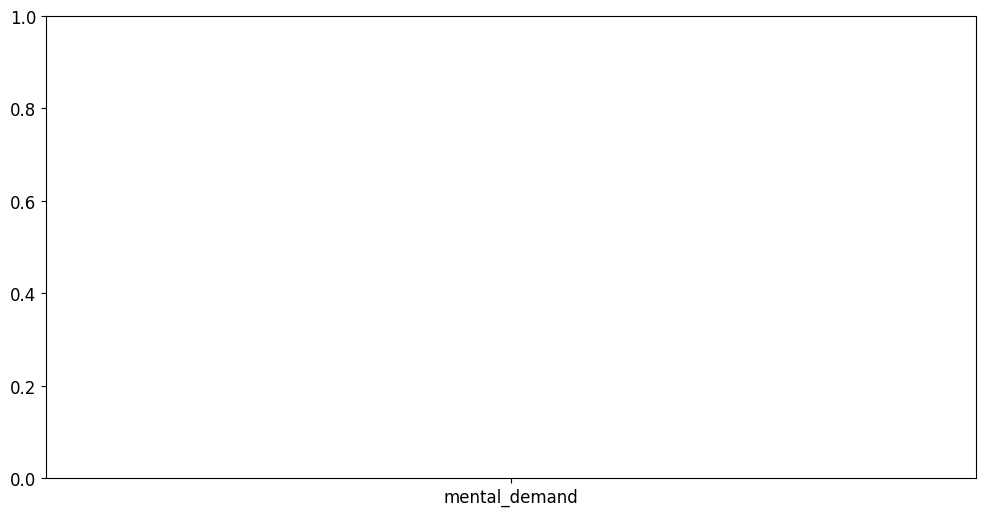

In [ ]:
# prompt: ローカルのjsonを読み込んで可視化したい.conditionごとに比較するようなグラフを作りたい．

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_json_data(json_file):
    # JSONファイルを読み込む
    with open(json_file, 'r') as f:
        data = json.load(f)

    # データフレームに変換
    df = pd.DataFrame(data)

    # フォントサイズを設定
    plt.rcParams.update({'font.size': 12})

    # 1. 試行タイプの分布
    plt.figure(figsize=(12, 6))
    trial_types = df['trial_type'].value_counts()
    sns.barplot(x=trial_types.index, y=trial_types.values)
    plt.title('Distribution of Trial Types')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('trial_types_distribution.png')
    plt.close()

    # 2. ビデオ質問の正答率
    video_questions = df[df['task'] == 'cnn_video_questions']
    if not video_questions.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='video_number', y='num_correct', hue='condition', data=video_questions)
        plt.title('Correct Answers by Video and Condition')
        plt.xlabel('Video Number')
        plt.ylabel('Number of Correct Answers')
        plt.legend(title='Condition')
        plt.tight_layout()
        plt.savefig('video_performance.png')
        plt.close()

    # 3. NASA-TLX スコアの可視化
    nasa_tlx = df[df['task'] == 'nasa_tlx']
    nasa_metrics = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    nasa_data = []
    for _, row in nasa_tlx.iterrows():
        for metric in nasa_metrics:
            if isinstance(row['response'], dict) and metric in row['response']:
                nasa_data.append({'Metric': metric, 'Score': row['response'][metric], 'Condition': row.get('condition', 'Unknown')})
    nasa_df = pd.DataFrame(nasa_data)

    if not nasa_df.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Metric', y='Score', hue='Condition', data=nasa_df)
        plt.title('NASA-TLX Scores Distribution by Condition')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('nasa_tlx_scores.png')
        plt.close()

    # 4. 動画に関する質問の回答分布
    video_survey = df[df['task'] == 'video_questions']
    survey_data = []
    for _, row in video_survey.iterrows():
        if isinstance(row['response'], dict):
            for key, value in row['response'].items():
                if key not in ['dummy']:
                    survey_data.append({'Question': key, 'Score': value, 'Condition': row.get('condition', 'Unknown')})
    survey_df = pd.DataFrame(survey_data)

    if not survey_df.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Question', y='Score', hue='Condition', data=survey_df)
        plt.title('Video Survey Responses Distribution by Condition')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('video_survey_responses.png')
        plt.close()

    # 5. 実験の全体的な時間の流れ
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='trial_index', y='time_elapsed', hue='task', data=df)
    plt.title('Experiment Timeline')
    plt.xlabel('Trial Index')
    plt.ylabel('Time Elapsed (ms)')
    plt.legend(title='Task', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('experiment_timeline.png')
    plt.close()

    # 6. 条件ごとの正答率の比較
    if 'condition' in video_questions.columns and 'num_correct' in video_questions.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='condition', y='num_correct', data=video_questions)
        plt.title('Correct Answers Distribution by Condition')
        plt.xlabel('Condition')
        plt.ylabel('Number of Correct Answers')
        plt.tight_layout()
        plt.savefig('condition_performance.png')
        plt.close()

    # 7. 反応時間の分布
    if 'rt' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['rt'].dropna(), bins=30, kde=True)
        plt.title('Distribution of Response Times')
        plt.xlabel('Response Time (ms)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.savefig('response_time_distribution.png')
        plt.close()

    print("Visualization complete. Check the generated PNG files.")

# 使用例
visualize_json_data('/content/d4zy36cjhq.json')


UnboundLocalError: local variable 'boxprops' referenced before assignment

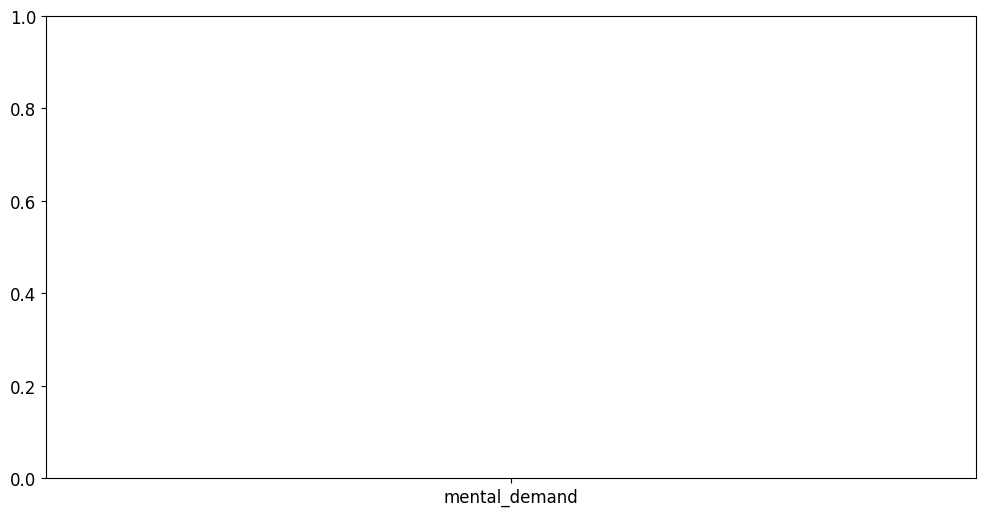

In [ ]:
# prompt: ローカルのjsonを読み込んで可視化したい.conditionごとに比較するようなグラフを作りたい．

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_json_data(json_file):
    # JSONファイルを読み込む
    with open(json_file, 'r') as f:
        data = json.load(f)

    # データフレームに変換
    df = pd.DataFrame(data)

    # フォントサイズを設定
    plt.rcParams.update({'font.size': 12})

    # 1. 試行タイプの分布
    plt.figure(figsize=(12, 6))
    trial_types = df['trial_type'].value_counts()
    sns.barplot(x=trial_types.index, y=trial_types.values)
    plt.title('Distribution of Trial Types')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('trial_types_distribution.png')
    plt.close()

    # 2. ビデオ質問の正答率
    video_questions = df[df['task'] == 'cnn_video_questions']
    if not video_questions.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='video_number', y='num_correct', hue='condition', data=video_questions)
        plt.title('Correct Answers by Video and Condition')
        plt.xlabel('Video Number')
        plt.ylabel('Number of Correct Answers')
        plt.legend(title='Condition')
        plt.tight_layout()
        plt.savefig('video_performance.png')
        plt.close()

    # 3. NASA-TLX スコアの可視化
    nasa_tlx = df[df['task'] == 'nasa_tlx']
    nasa_metrics = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    nasa_data = []
    for _, row in nasa_tlx.iterrows():
        for metric in nasa_metrics:
            if isinstance(row['response'], dict) and metric in row['response']:
                nasa_data.append({'Metric': metric, 'Score': row['response'][metric], 'Condition': row.get('condition', 'Unknown')})
    nasa_df = pd.DataFrame(nasa_data)

    if not nasa_df.empty:
        plt.figure(figsize=(12, 6))
        # Remove `dodge=False` to ensure `boxprops` is assigned.
        sns.boxplot(x='Metric', y='Score', hue='Condition', data=nasa_df)
        plt.title('NASA-TLX Scores Distribution by Condition')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('nasa_tlx_scores.png')
        plt.close()

    # 4. 動画に関する質問の回答分布
    video_survey = df[df['task'] == 'video_questions']
    survey_data = []
    for _, row in video_survey.iterrows():
        if isinstance(row['response'], dict):
            for key, value in row['response'].items():
                if key not in ['dummy']:
                    survey_data.append({'Question': key, 'Score': value, 'Condition': row.get('condition', 'Unknown')})
    survey_df = pd.DataFrame(survey_data)

    if not survey_df.empty:
        plt.figure(figsize=(12, 6))
        # Remove `dodge=False` to ensure `boxprops` is assigned.
        sns.boxplot(x='Question',y='Score', hue='Condition', data=survey_df)
        plt.title('Video Survey Responses Distribution by Condition')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('video_survey_responses.png')
        plt.close()

    # 5. 実験の全体的な時間の流れ
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='trial_index', y='time_elapsed', hue='task', data=df)
    plt.title('Experiment Timeline')
    plt.xlabel('Trial Index')
    plt.ylabel('Time Elapsed (ms)')
    plt.legend(title='Task', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('experiment_timeline.png')
    plt.close()

    # 6. 条件ごとの正答率の比較
    if 'condition' in video_questions.columns and 'num_correct' in video_questions.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='condition', y='num_correct', data=video_questions)
        plt.title('Correct Answers Distribution by Condition')
        plt.xlabel('Condition')
        plt.ylabel('Number of Correct Answers')
        plt.tight_layout()
        plt.savefig('condition_performance.png')
        plt.close()

    # 7. 反応時間の分布
    if 'rt' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['rt'].dropna(), bins=30, kde=True)
        plt.title('Distribution of Response Times')
        plt.xlabel('Response Time (ms)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.savefig('response_time_distribution.png')
        plt.close()

    print("Visualization complete. Check the generated PNG files.")

# 使用例
visualize_json_data('/content/d4zy36cjhq.json')

# データ可視化

## マウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1個だけのデータを読む

In [ ]:
# prompt: ローカルのjsonを読み込みたい. データフレームを自分で操作したい

import pandas as pd
import json

# ローカルのJSONファイルのパスを指定
file_path = '/content/d4zy36cjhq.json'

# JSONファイルを読み込む
with open(file_path, 'r') as f:
  data = json.load(f)

# データフレームに変換
df = pd.DataFrame(data)

# データフレームを操作する例
print(df.head())  # 最初の5行を表示
print(df.describe())  # 各列の統計量を表示
# print(df['column_name'].value_counts())  # 特定の列の値の出現回数をカウント

df

               trial_type  trial_index  time_elapsed internal_node_id  \
0           call-function            0             2          0.0-0.0   
1    html-button-response            1          1261          0.0-1.0   
2  html-keyboard-response            2          2392          0.0-2.0   
3        survey-html-form            3         37860          0.0-3.0   
4    html-button-response            4         38859          0.0-4.0   

   subject_id PROLIFIC_PID STUDY_ID SESSION_ID  \
0  d4zy36cjhq         None     None       None   
1  d4zy36cjhq         None     None       None   
2  d4zy36cjhq         None     None       None   
3  d4zy36cjhq         None     None       None   
4  d4zy36cjhq         None     None       None   

                                       paramsPresent       rt  ...  \
0  {'PROLIFIC_PID': False, 'STUDY_ID': False, 'SE...      NaN  ...   
1  {'PROLIFIC_PID': False, 'STUDY_ID': False, 'SE...   1258.0  ...   
2  {'PROLIFIC_PID': False, 'STUDY_ID': False, 'SE.

trial_type  trial_index  time_elapsed internal_node_id  \
0             call-function            0             2          0.0-0.0   
1      html-button-response            1          1261          0.0-1.0   
2    html-keyboard-response            2          2392          0.0-2.0   
3          survey-html-form            3         37860          0.0-3.0   
4      html-button-response            4         38859          0.0-4.0   
5   audio-keyboard-response            5        214100      0.0-5.0-0.0   
6      html-button-response            6        238201      0.0-5.0-1.0   
7      html-button-response            7        240251          0.0-6.0   
8   video-keyboard-response            8        276600      0.0-7.0-0.0   
9             survey-likert            9        315015      0.0-7.0-1.0   
10      survey-multi-choice           10        345230      0.0-7.0-2.0   
11            survey-likert           11        360414      0.0-7.0-3.0   
12  video-keyboard-response           12        405343      0.0-7.0-0.1   
13            survey-likert           13        413160      0.0-7.0-1.1   
14      survey-multi-choice           14        434410      0.0-7.0-2.1   
15            survey-likert           15        448495      0.0-7.0-3.1   
16  video-keyboard-response           16        498650      0.0-7.0-0.2   
17            survey-likert           17        512924      0.0-7.0-1.2   
18      survey-multi-choice           18        539322      0.0-7.0-2.2   
19            survey-likert           19        555955      0.0-7.0-3.2   
20  video-keyboard-response           20        588563      0.0-7.0-0.3   
21            survey-likert           21        629170      0.0-7.0-1.3   
22      survey-multi-choice           22        647537      0.0-7.0-2.3   
23            survey-likert           23        662834      0.0-7.0-3.3   
24  video-keyboard-response           24        712895      0.0-7.0-0.4   
25            survey-likert           25        725831      0.0-7.0-1.4   
26      survey-multi-choice           26        738664      0.0-7.0-2.4   
27            survey-likert           27        769130      0.0-7.0-3.4   
28  video-keyboard-response           28        811308      0.0-7.0-0.5   
29            survey-likert           29        822161      0.0-7.0-1.5   
30      survey-multi-choice           30        833994      0.0-7.0-2.5   
31            survey-likert           31        848661      0.0-7.0-3.5   
32         survey-html-form           32        859225          0.0-8.0   
33              survey-text           33        876613          0.0-9.0   

    subject_id PROLIFIC_PID STUDY_ID SESSION_ID  \
0   d4zy36cjhq         None     None       None   
1   d4zy36cjhq         None     None       None   
2   d4zy36cjhq         None     None       None   
3   d4zy36cjhq         None     None       None   
4   d4zy36cjhq         None     None       None   
5   d4zy36cjhq         None     None       None   
6   d4zy36cjhq         None     None       None   
7   d4zy36cjhq         None     None       None   
8   d4zy36cjhq         None     None       None   
9   d4zy36cjhq         None     None       None   
10  d4zy36cjhq         None     None       None   
11  d4zy36cjhq         None     None       None   
12  d4zy36cjhq         None     None       None   
13  d4zy36cjhq         None     None       None   
14  d4zy36cjhq         None     None       None   
15  d4zy36cjhq         None     None       None   
16  d4zy36cjhq         None     None       None   
17  d4zy36cjhq         None     None       None   
18  d4zy36cjhq         None     None       None   
19  d4zy36cjhq         None     None       None   
20  d4zy36cjhq         None     None       None   
21  d4zy36cjhq         None     None       None   
22  d4zy36cjhq         None     None       None   
23  d4zy36cjhq         None     None       None   
24  d4zy36cjhq         None     None       None   
25  d4zy36cjhq         None     None       None   
26  d4zy36cjhq

## 全てのデータ

1. Demographic情報:
       gender age nationality native_language other_language1 other_language2  \
count      62  62          62              62              57              57   
unique      3  20          20              16               9               8   
top       man  26    Portugal         English         English                   
freq       34  11           9              17              35              32   

       other_language3 toefl_score toeic_score ielts_score other_languages  \
count               57          57          57          57               5   
unique               7           5           4           2               2   
top                                                                English   
freq                51          52          54          56               4   

       english_test english_score  
count             5             5  
unique            3             5  
top           TOEFL           109  
freq              3             1  

2. T

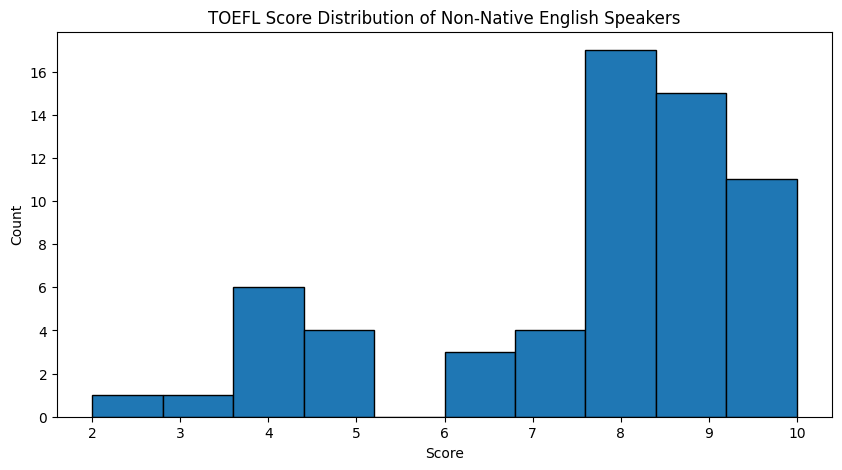


3. 実験動画への回答:
           video_number  comprehension  engagement  readability  num_correct  \
condition                                                                      
dynamik        4.790323       1.080645    1.370968     1.645161     5.629032   
keyword        5.451613       1.677419    2.096774     2.661290     5.080645   
normal         5.258065       0.983871    1.564516     1.354839     5.274194   

           mental_demand  physical_demand  temporal_demand  performance  \
condition                                                                 
dynamik         2.935484         1.225806         2.822581     1.951613   
keyword         3.274194         1.548387         2.967742     2.725806   
normal          2.806452         1.129032         2.516129     2.209677   

             effort  frustration  
condition                         
dynamik    2.693548     2.096774  
keyword    3.096774     2.790323  
normal     2.951613     2.112903  


<ipython-input-2-26ac3ff600d9>:96: UserWarning: Glyph 23455 (\N{CJK UNIFIED IDEOGRAPH-5B9F}) missing from current font.
  plt.tight_layout()
<ipython-input-2-26ac3ff600d9>:96: UserWarning: Glyph 39443 (\N{CJK UNIFIED IDEOGRAPH-9A13}) missing from current font.
  plt.tight_layout()
<ipython-input-2-26ac3ff600d9>:96: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from current font.
  plt.tight_layout()
<ipython-input-2-26ac3ff600d9>:96: UserWarning: Glyph 30011 (\N{CJK UNIFIED IDEOGRAPH-753B}) missing from current font.
  plt.tight_layout()
<ipython-input-2-26ac3ff600d9>:96: UserWarning: Glyph 12408 (\N{HIRAGANA LETTER HE}) missing from current font.
  plt.tight_layout()
<ipython-input-2-26ac3ff600d9>:96: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
<ipython-input-2-26ac3ff600d9>:96: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  plt.tight_layout()
<ipython-input-2-26ac3ff600d9

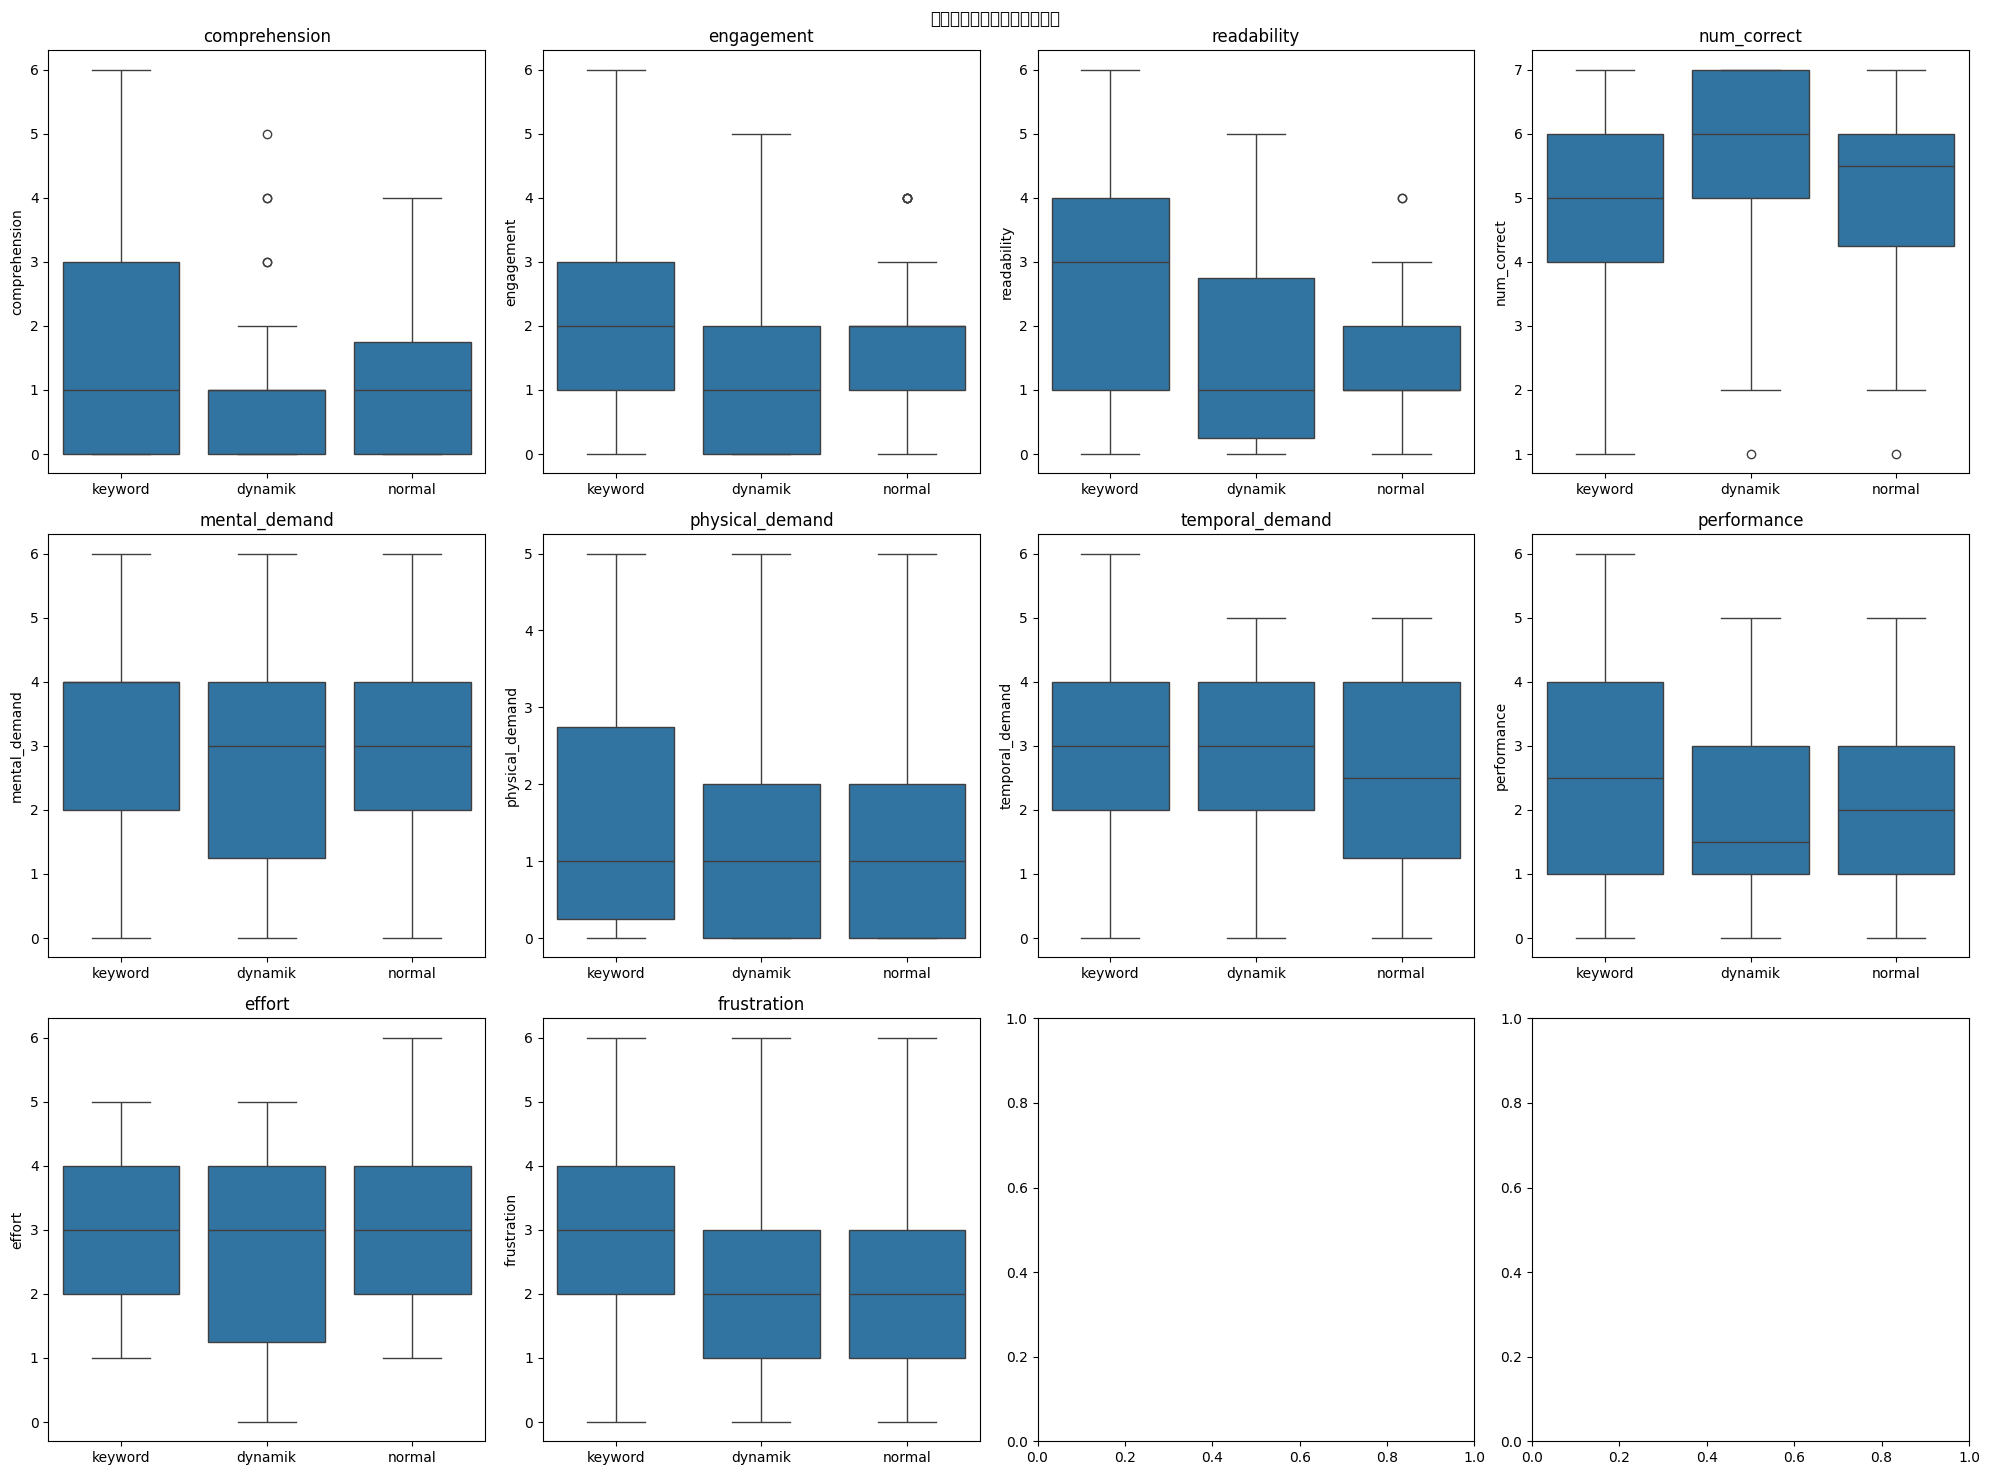


4. 条件の順位づけの割合:
('2', '3', '1'): 37.10%
('1', '3', '2'): 25.81%
('1', '2', '3'): 24.19%
('2', '1', '3'): 6.45%
('3', '2', '1'): 3.23%
('3', '1', '2'): 3.23%

5. 実験全体の感想:
- very interesting to see how format of subtitles can affect understanding 
- 
- It was quite demanding, especially with the keywords. 
- 
- It was really easy to do and it was mentally stimulating 
- I guess I&#39;m stating the obvious by poining out that this didn&#39;t really test listening comprehension as much as memory.
- enjoyed
- 
- 
- Fun experiment, thank you
- good
- Extrange
- nice
- interesting. I found the news artciles very interesting
- Despite the low quality (audiowise) of some of the clips, I believe that the language in all of the audio is fairly easy to comprehend.
- its a refreshing subject, never done a study like this and i was afraid that i could be cut out from it because English is not my native language. 
i liked the &#39;keyboard&#39; subtitles as a form of making a resume to study in a wor

In [2]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# JSONファイルを読み込む関数
def load_json_files(pattern):
    data = []
    for file in glob.glob(pattern):
        with open(file, 'r') as f:
            data.extend(json.load(f))
    return data

# データを読み込む
# data = load_json_files('/content/*.json')
data = load_json_files('/content/drive/MyDrive/山下先生ネタ/json/*.json')


# 1. Demographic情報
def get_demographics(data):
    demographics = []
    for trial in data:
        if trial.get('task') == 'demographic_survey':
            demographics.append(trial['response'])
    return pd.DataFrame(demographics)

demographics = get_demographics(data)
print("1. Demographic情報:")
print(demographics.describe())

# 2. TOEFLの正答数
def get_toefl_scores(data):
    toefl_scores = []
    for trial in data:
        if trial.get('trial_index') == 6:
            toefl_scores.append(trial.get('num_correct', 0))
    return toefl_scores

toefl_scores = get_toefl_scores(data)
print("\n2. TOEFLの正答数:")
print(f"平均: {sum(toefl_scores) / len(toefl_scores):.2f}")
print(f"最小: {min(toefl_scores)}, 最大: {max(toefl_scores)}")

# TOEFLスコアの分布
plt.figure(figsize=(10, 5))
plt.hist(toefl_scores, bins=10, edgecolor='black')
plt.title('TOEFL Score Distribution of Non-Native English Speakers')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()



# 3. 実験動画への回答について
def get_video_responses(data):
    responses = []
    for i in range(0, len(data), 4):
        if data[i].get('task') == 'cnn_video':
            video_data = {
                'condition': data[i]['condition'],
                'video_number': data[i]['video_number'],
                'comprehension': data[i+1]['response']['comprehension'],
                'engagement': data[i+1]['response']['engagement'],
                'readability': data[i+1]['response']['readability'],
                'num_correct': data[i+2]['num_correct'],
                'mental_demand': data[i+3]['response']['mental_demand'],
                'physical_demand': data[i+3]['response']['physical_demand'],
                'temporal_demand': data[i+3]['response']['temporal_demand'],
                'performance': data[i+3]['response']['performance'],
                'effort': data[i+3]['response']['effort'],
                'frustration': data[i+3]['response']['frustration']
            }
            responses.append(video_data)
    return pd.DataFrame(responses)

video_responses = get_video_responses(data)

print("\n3. 実験動画への回答:")
print(video_responses.groupby('condition').mean())

# 箱ひげ図の作成
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('実験動画への回答の箱ひげ図')

metrics = ['comprehension', 'engagement', 'readability', 'num_correct',
           'mental_demand', 'physical_demand', 'temporal_demand', 'performance',
           'effort', 'frustration']

for i, metric in enumerate(metrics):
    ax = axes[i // 4, i % 4]
    sns.boxplot(x='condition', y=metric, data=video_responses, ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

# 4. どの条件が良かったかの順位づけの割合
def get_preference_rankings(data):
    rankings = []
    for trial in data:
        if trial.get('task') == 'subtitle_preference':
            response = trial['response']
            ranking = (response['normal'], response['keyword'], response['dynamik'])
            rankings.append(ranking)
    return rankings

preference_rankings = get_preference_rankings(data)
ranking_counts = pd.Series(preference_rankings).value_counts()

print("\n4. 条件の順位づけの割合:")
for ranking, count in ranking_counts.items():
    print(f"{ranking}: {count / len(preference_rankings):.2%}")

# 5. 実験全体の感想
def get_feedback(data):
    feedback = []
    for trial in data:
        if trial.get('task') == 'final_feedback':
            feedback.append(trial['response']['Q0'])
    return feedback

feedback = get_feedback(data)
print("\n5. 実験全体の感想:")
for comment in feedback:
    print(f"- {comment}")

1. Demographic情報:
       gender age nationality native_language other_language1 other_language2  \
count      60  60          60              60              55              55   
unique      3  19          20              16               9               8   
top       man  26    Portugal         English         English                   
freq       32  11           9              17              33              30   

       other_language3 toefl_score toeic_score ielts_score other_languages  \
count               55          55          55          55               5   
unique               7           5           4           2               2   
top                                                                English   
freq                49          50          52          54               4   

       english_test english_score  
count             5             5  
unique            3             5  
top           TOEFL           109  
freq              3             1  


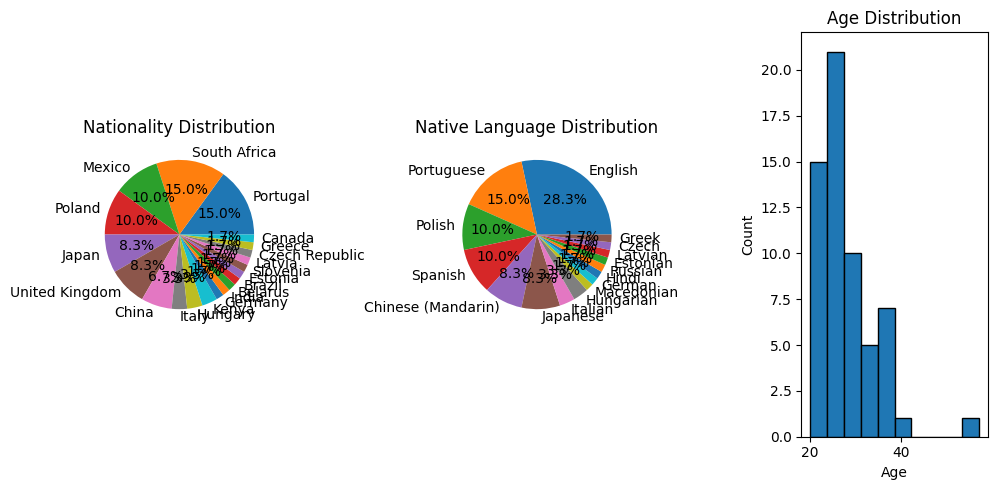


Gender Distribution:
man: 32 (53.3%)
woman: 26 (43.3%)
non-binary: 2 (3.3%)

Other Languages:
                      89
English               39
Spanish                7
French                 7
German                 4
Xhosa                  3
Japanese               3
Russian                3
Portuguese             2
Swahili                2
Afrikaans              2
Slovenian              1
Chinese (Mandarin)     1
Serbian                1
Latin                  1
Name: count, dtype: int64

Language Test Scores:
TOEFL_SCORE:
  Mean: 86.20
  Median: 88.00
  Min: 80.00
  Max: 90.00
  Count: 5
TOEIC_SCORE:
  Mean: 860.00
  Median: 925.00
  Min: 705.00
  Max: 950.00
  Count: 3
IELTS_SCORE:
  Mean: 6.50
  Median: 6.50
  Min: 6.50
  Max: 6.50
  Count: 1


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Demographic情報の可視化
def visualize_demographics(demographics):
    # Nationalityの円グラフ
    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    nationality_counts = demographics['nationality'].value_counts()
    plt.pie(nationality_counts.values, labels=nationality_counts.index, autopct='%1.1f%%')
    plt.title('Nationality Distribution')

    # Native Languageの円グラフ
    plt.subplot(132)
    language_counts = demographics['native_language'].value_counts()
    plt.pie(language_counts.values, labels=language_counts.index, autopct='%1.1f%%')
    plt.title('Native Language Distribution')

    # Ageのヒストグラム
    plt.subplot(133)
    plt.hist(demographics['age'].astype(int), bins=10, edgecolor='black')
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# Demographic情報の取得と可視化
demographics = get_demographics(data)
print("1. Demographic情報:")
print(demographics.describe())

visualize_demographics(demographics)

# Gender分布の表示
gender_counts = demographics['gender'].value_counts()
print("\nGender Distribution:")
for gender, count in gender_counts.items():
    print(f"{gender}: {count} ({count / len(demographics) * 100:.1f}%)")

# その他の言語の分布
other_languages = pd.concat([demographics['other_language1'], demographics['other_language2'], demographics['other_language3']]).value_counts()
print("\nOther Languages:")
print(other_languages)

# TOEFL, TOEIC, IELTSスコアの要約
print("\nLanguage Test Scores:")
for test in ['toefl_score', 'toeic_score', 'ielts_score']:
    scores = demographics[test].replace('', np.nan).dropna()
    scores = pd.to_numeric(scores, errors='coerce')
    if not scores.empty:
        print(f"{test.upper()}:")
        print(f"  Mean: {scores.mean():.2f}")
        print(f"  Median: {scores.median():.2f}")
        print(f"  Min: {scores.min():.2f}")
        print(f"  Max: {scores.max():.2f}")
        print(f"  Count: {scores.count()}")
    else:
        print(f"{test.upper()}: No valid scores")

## 非英語ネイティブのみ


Language Test Scores for Non-Native English Speakers:
TOEFL_SCORE:
  Mean: 85.25
  Median: 86.50
  Min: 80.00
  Max: 88.00
  Count: 4


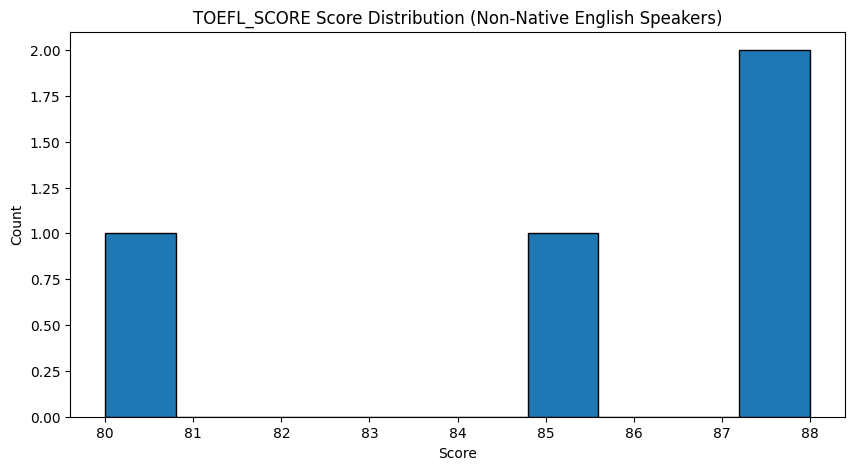

TOEIC_SCORE:
  Mean: 937.50
  Median: 937.50
  Min: 925.00
  Max: 950.00
  Count: 2


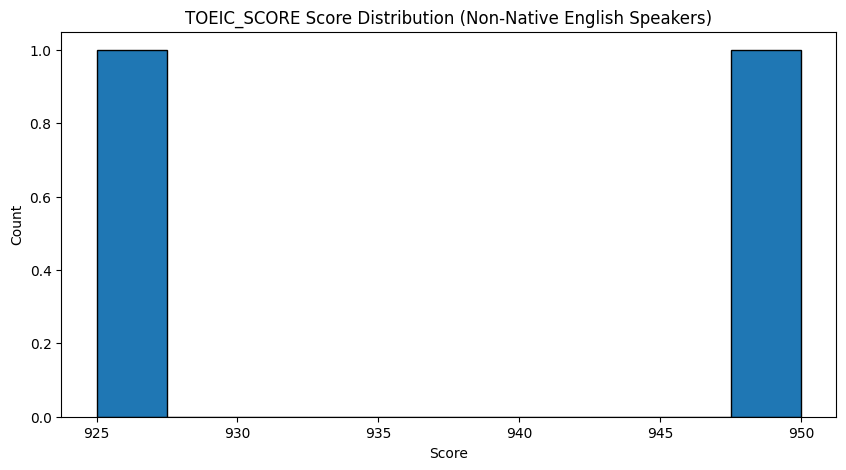

IELTS_SCORE: No valid scores


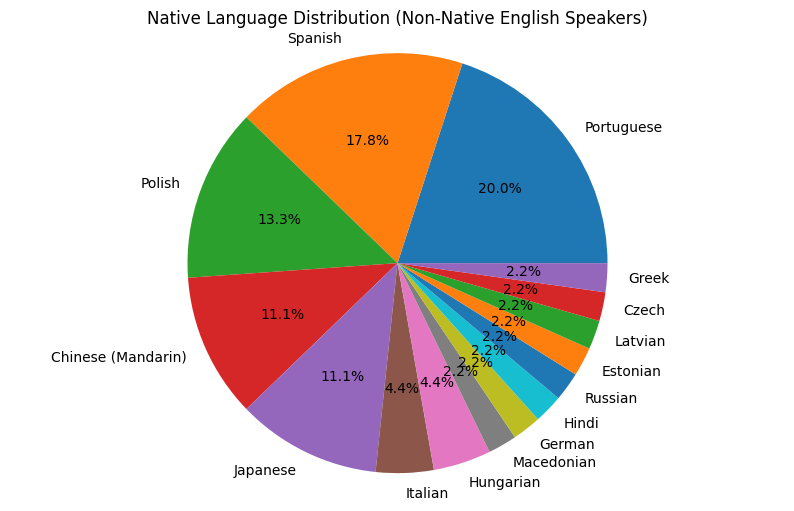


Native Language Distribution for Non-Native English Speakers:
Portuguese: 9 (20.0%)
Spanish: 8 (17.8%)
Polish: 6 (13.3%)
Chinese (Mandarin): 5 (11.1%)
Japanese: 5 (11.1%)
Italian: 2 (4.4%)
Hungarian: 2 (4.4%)
Macedonian: 1 (2.2%)
German: 1 (2.2%)
Hindi: 1 (2.2%)
Russian: 1 (2.2%)
Estonian: 1 (2.2%)
Latvian: 1 (2.2%)
Czech: 1 (2.2%)
Greek: 1 (2.2%)


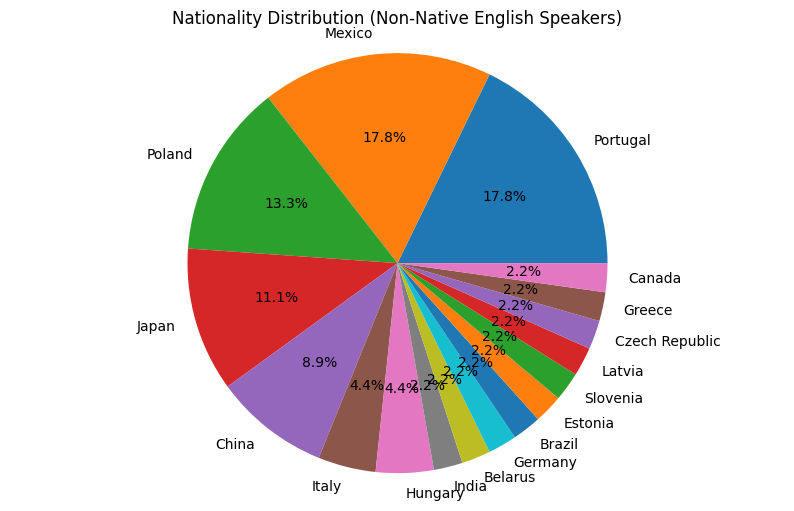


Nationality Distribution for Non-Native English Speakers:
Portugal: 8 (17.8%)
Mexico: 8 (17.8%)
Poland: 6 (13.3%)
Japan: 5 (11.1%)
China: 4 (8.9%)
Italy: 2 (4.4%)
Hungary: 2 (4.4%)
India: 1 (2.2%)
Belarus: 1 (2.2%)
Germany: 1 (2.2%)
Brazil: 1 (2.2%)
Estonia: 1 (2.2%)
Slovenia: 1 (2.2%)
Latvia: 1 (2.2%)
Czech Republic: 1 (2.2%)
Greece: 1 (2.2%)
Canada: 1 (2.2%)


In [4]:
import numpy as np
import pandas as pd

# 英語を第一言語としない人のデータフィルタリング
non_native_english = demographics[demographics['native_language'] != 'English']

print("\nLanguage Test Scores for Non-Native English Speakers:")
for test in ['toefl_score', 'toeic_score', 'ielts_score']:
    scores = non_native_english[test].replace('', np.nan).dropna()
    scores = pd.to_numeric(scores, errors='coerce')
    if not scores.empty:
        print(f"{test.upper()}:")
        print(f"  Mean: {scores.mean():.2f}")
        print(f"  Median: {scores.median():.2f}")
        print(f"  Min: {scores.min():.2f}")
        print(f"  Max: {scores.max():.2f}")
        print(f"  Count: {scores.count()}")

        # スコア分布のヒストグラムを描画
        plt.figure(figsize=(10, 5))
        plt.hist(scores, bins=10, edgecolor='black')
        plt.title(f'{test.upper()} Score Distribution (Non-Native English Speakers)')
        plt.xlabel('Score')
        plt.ylabel('Count')
        plt.show()
    else:
        print(f"{test.upper()}: No valid scores")

# 非英語ネイティブの言語分布
non_native_languages = non_native_english['native_language'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(non_native_languages.values, labels=non_native_languages.index, autopct='%1.1f%%')
plt.title('Native Language Distribution (Non-Native English Speakers)')
plt.axis('equal')
plt.show()

print("\nNative Language Distribution for Non-Native English Speakers:")
for language, count in non_native_languages.items():
    print(f"{language}: {count} ({count / len(non_native_english) * 100:.1f}%)")

# 非英語ネイティブの国籍分布
non_native_nationalities = non_native_english['nationality'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(non_native_nationalities.values, labels=non_native_nationalities.index, autopct='%1.1f%%')
plt.title('Nationality Distribution (Non-Native English Speakers)')
plt.axis('equal')
plt.show()

print("\nNationality Distribution for Non-Native English Speakers:")
for nationality, count in non_native_nationalities.items():
    print(f"{nationality}: {count} ({count / len(non_native_english) * 100:.1f}%)")

1. 非英語話者の Demographic 情報:
       gender age nationality native_language other_language1 other_language2  \
count      45  45          45              45              40              40   
unique      3  16          17              15               5               8   
top       man  26    Portugal      Portuguese         English                   
freq       24  11           8               9              35              19   

       other_language3 toefl_score toeic_score ielts_score  \
count               40          40          40          40   
unique               5           4           3           1   
top                                                          
freq                36          36          38          40   

                      subject_id              PROLIFIC_PID  \
count                         45                        31   
unique                        45                        31   
top     6697e7c43843491550b0b41b  6697e7c43843491550b0b41b   
freq     

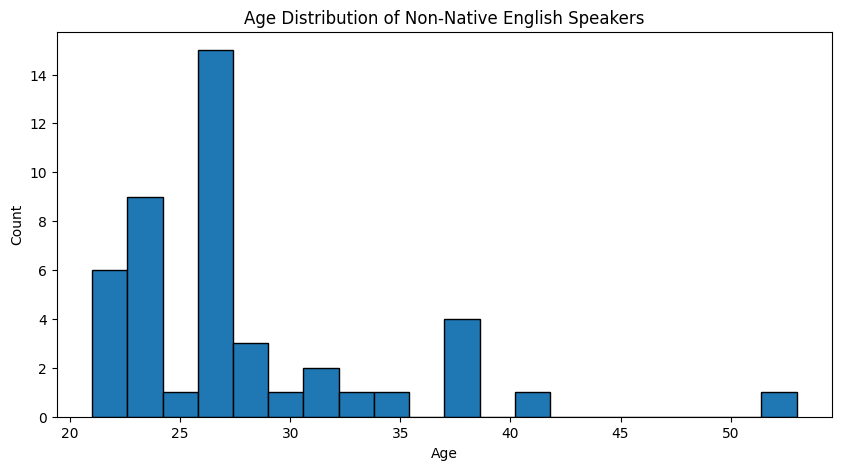

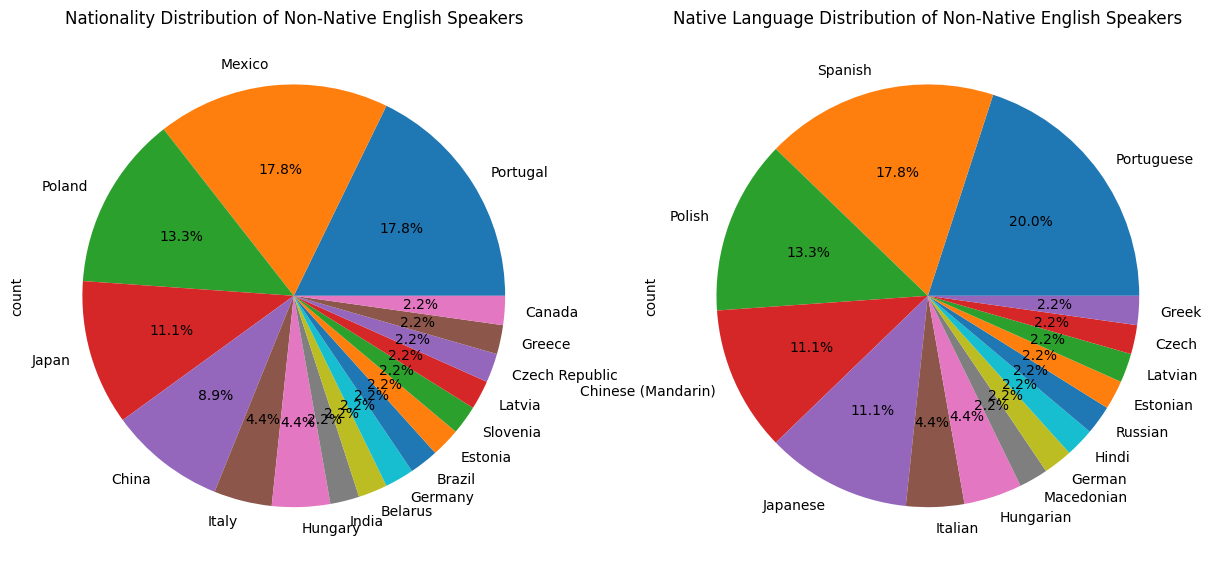

Subject 6691d1c25524897b604ba5e5 not in non_native_ids
Subject 6130e97d4106299f8c6120fa not in non_native_ids
Subject 6112aa865f237cf99d0b0094 not in non_native_ids
Subject 614929e5dc437220dafb260c not in non_native_ids
Subject 5adf69c1944de80001ddc254 not in non_native_ids
Subject 5b9d73ec6b0f63000148db87 not in non_native_ids
Subject 5e9e04d94b0db1198f8cf304 not in non_native_ids
Subject 5f2e48f9498e160008a60d2d not in non_native_ids
Subject 60e7218db2691424068d718c not in non_native_ids
Subject 62b055a21e169809861b173d not in non_native_ids
Subject 65fb3d17ba1b0d7cb319e626 not in non_native_ids
Subject 65faeb354511dc84270f57b5 not in non_native_ids
Subject 66b0d089831edd1c2a5526d3 not in non_native_ids
Subject 66a7d34d55854d7eb5751740 not in non_native_ids
Subject 66b37757336c387989fb56ac not in non_native_ids
Subject 66d9aba3fe0ba40da19b96ab not in non_native_ids
Subject 615dd36156bf443246c0b660 not in non_native_ids

2. 非英語話者の TOEFL の正答数:
平均: 7.24
最小: 2
最大: 10


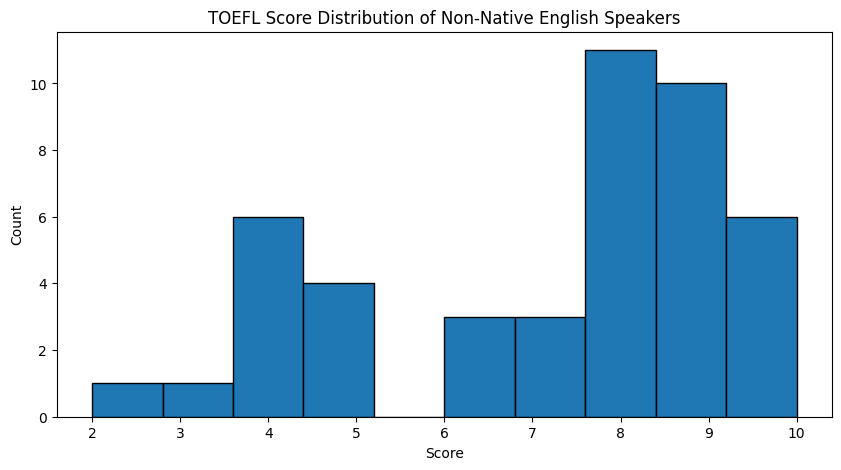


3. 非英語話者の実験動画への回答（条件別平均）:
           video_number  comprehension  engagement  readability  num_correct  \
condition                                                                      
dynamik        4.717391       1.108696    1.500000     1.673913     5.456522   
keyword        5.434783       1.978261    2.369565     2.956522     5.086957   
normal         5.347826       1.021739    1.739130     1.413043     5.434783   

           mental_demand  physical_demand  temporal_demand  performance  \
condition                                                                 
dynamik         3.065217         1.478261         2.847826     2.000000   
keyword         3.369565         1.782609         3.000000     2.913043   
normal          3.000000         1.260870         2.608696     2.326087   

             effort  frustration  
condition                         
dynamik    2.673913     2.304348  
keyword    3.282609     3.130435  
normal     2.956522     2.413043  


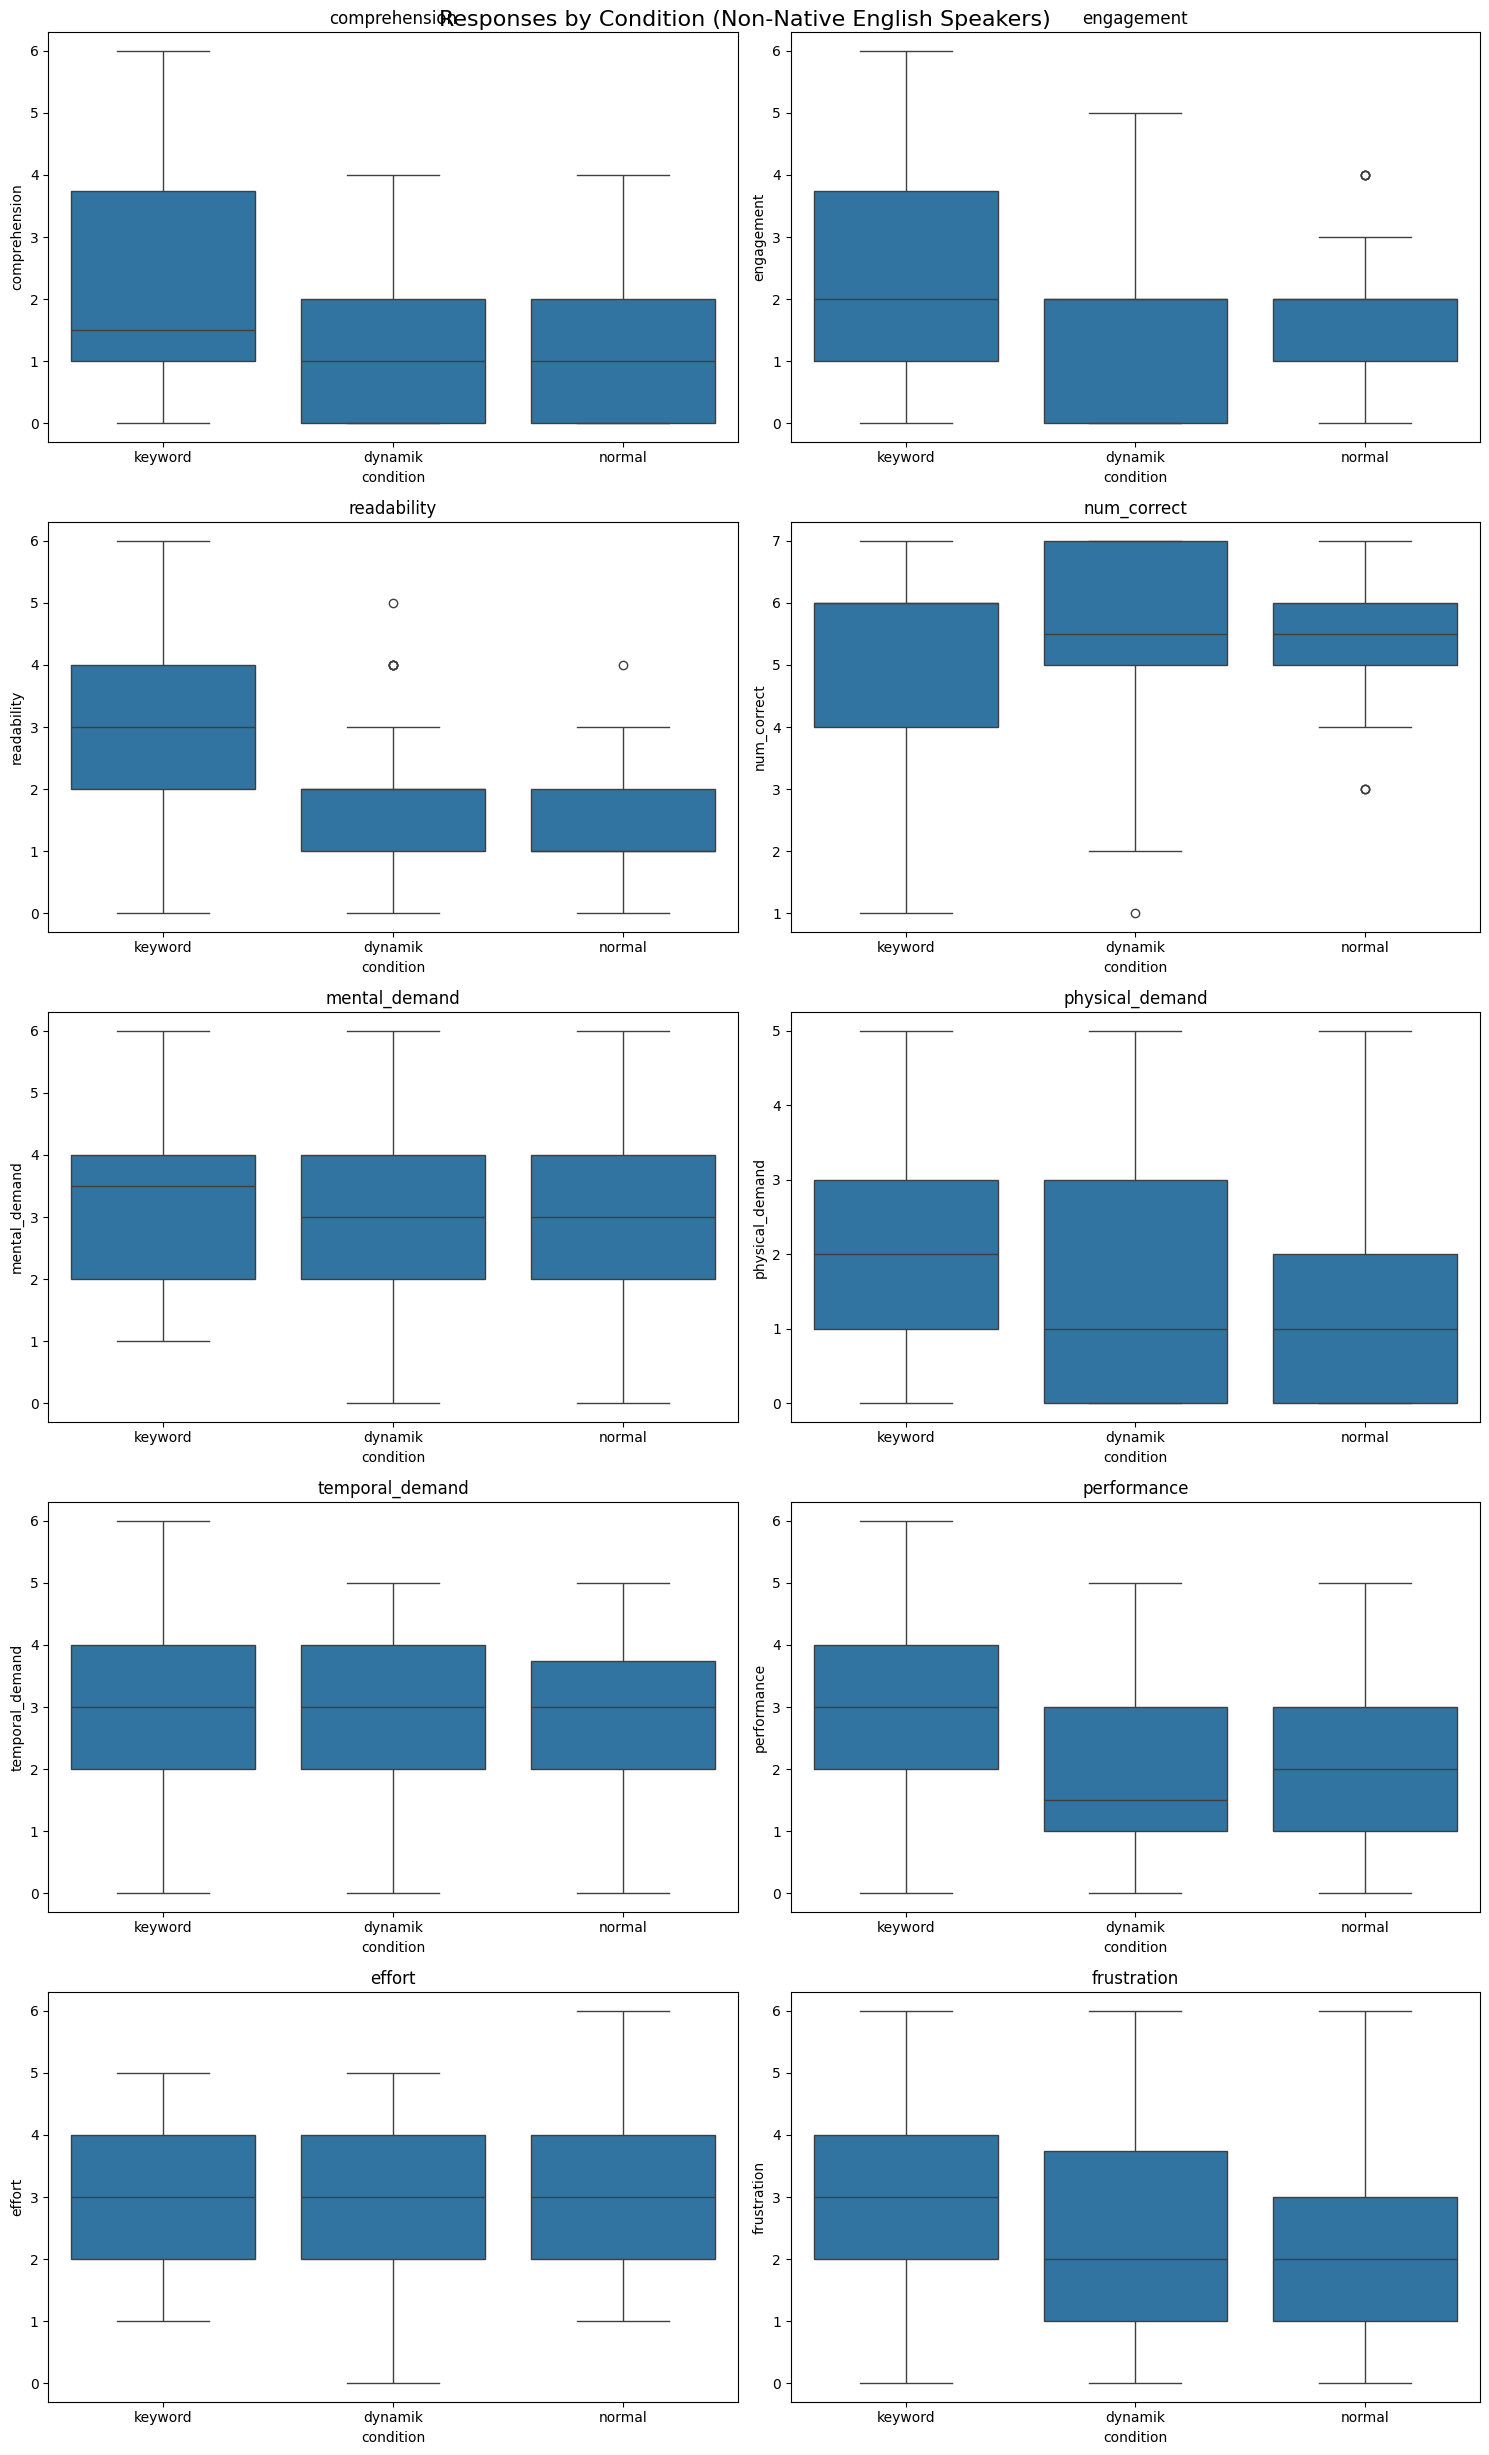


4. 非英語話者の条件の順位づけの割合:
('2', '3', '1'): 42.22%
('1', '2', '3'): 26.67%
('1', '3', '2'): 24.44%
('2', '1', '3'): 4.44%
('3', '1', '2'): 2.22%


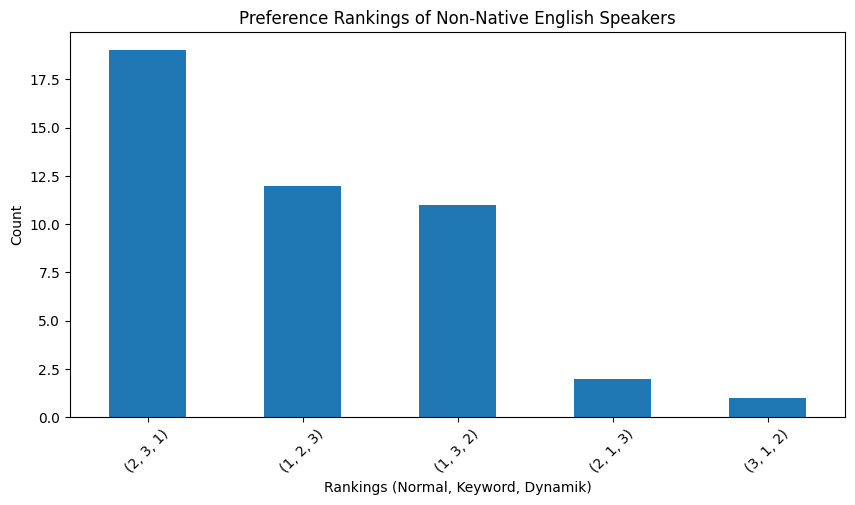


5. 非英語話者の実験全体の感想:
1. very interesting to see how format of subtitles can affect understanding 
2. 
3. It was quite demanding, especially with the keywords. 
4. I guess I&#39;m stating the obvious by poining out that this didn&#39;t really test listening comprehension as much as memory.
5. enjoyed
6. Fun experiment, thank you
7. good
8. Extrange
9. nice
10. Despite the low quality (audiowise) of some of the clips, I believe that the language in all of the audio is fairly easy to comprehend.
11. its a refreshing subject, never done a study like this and i was afraid that i could be cut out from it because English is not my native language. 
i liked the &#39;keyboard&#39; subtitles as a form of making a resume to study in a work environment 
12. 
13. I think those were auto subtitles and changed during the video and that made it a little bit harder to memorise
14. Everything worked fine slight suggestion is please let us control the volume of the clips used in the study it was deafeningl

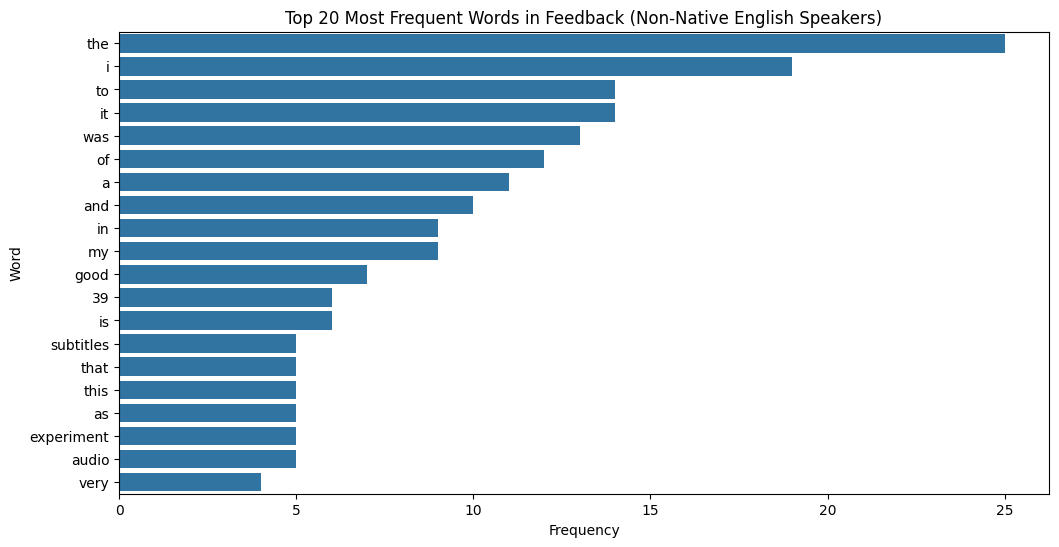

In [5]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

# データ読み込み関数（前回と同じ）
def load_json_files(pattern):
    data = []
    for file in glob.glob(pattern):
        with open(file, 'r') as f:
            data.extend(json.load(f))
    return data

# データを読み込む
data = load_json_files('/content/drive/MyDrive/山下先生ネタ/json/*.json')

# Demographic情報の取得
def get_demographics(data):
    demographics = []
    for trial in data:
        if trial.get('task') == 'demographic_survey':
            demo_data = trial['response'].copy()  # responseの内容をコピー
            # 追加の情報を含める
            demo_data['subject_id'] = trial.get('subject_id')
            demo_data['PROLIFIC_PID'] = trial.get('PROLIFIC_PID')
            demo_data['STUDY_ID'] = trial.get('STUDY_ID')
            demo_data['SESSION_ID'] = trial.get('SESSION_ID')
            demographics.append(demo_data)
    return pd.DataFrame(demographics)
demographics = get_demographics(data)

# 非英語話者のデータのみをフィルタリング
non_native_english = demographics[demographics['native_language'] != 'English']

# non_native_ids を作成
non_native_ids = set(non_native_english['subject_id'])

print("1. 非英語話者の Demographic 情報:")
print(non_native_english.describe())

# 年齢分布のヒストグラム
plt.figure(figsize=(10, 5))
plt.hist(non_native_english['age'].astype(int), bins=20, edgecolor='black')
plt.title('Age Distribution of Non-Native English Speakers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 国籍と母語の分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
non_native_english['nationality'].value_counts().plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Nationality Distribution of Non-Native English Speakers')
non_native_english['native_language'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Native Language Distribution of Non-Native English Speakers')
plt.show()

# 2. TOEFLの正答数（非英語話者のみ）
def get_toefl_scores(data, non_native_ids):
    toefl_scores = []
    for trial in data:
        if trial.get('trial_index') == 6:
            if trial.get('subject_id') in non_native_ids:
                score = trial.get('num_correct')
                if score is not None:
                    toefl_scores.append(score)
                else:
                    print(f"Warning: 'num_correct' not found for subject {trial.get('subject_id')}")
            else:
                print(f"Subject {trial.get('subject_id')} not in non_native_ids")

    if not toefl_scores:
        print("No TOEFL scores found for non-native speakers")

    return toefl_scores

toefl_scores = get_toefl_scores(data, non_native_ids)

if toefl_scores:
    print("\n2. 非英語話者の TOEFL の正答数:")
    print(f"平均: {np.mean(toefl_scores):.2f}")
    print(f"最小: {np.min(toefl_scores)}")
    print(f"最大: {np.max(toefl_scores)}")
else:
    print("No valid TOEFL scores found for analysis")

# TOEFLスコアの分布
plt.figure(figsize=(10, 5))
plt.hist(toefl_scores, bins=10, edgecolor='black')
plt.title('TOEFL Score Distribution of Non-Native English Speakers')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# 3. 実験動画への回答（非英語話者のみ）
def get_video_responses(data, non_native_ids):
    responses = []
    for i in range(0, len(data), 4):
        if data[i].get('task') == 'cnn_video' and data[i].get('subject_id') in non_native_ids:
            video_data = {
                'condition': data[i]['condition'],
                'video_number': data[i]['video_number'],
                'comprehension': data[i+1]['response']['comprehension'],
                'engagement': data[i+1]['response']['engagement'],
                'readability': data[i+1]['response']['readability'],
                'num_correct': data[i+2]['num_correct'],
                'mental_demand': data[i+3]['response']['mental_demand'],
                'physical_demand': data[i+3]['response']['physical_demand'],
                'temporal_demand': data[i+3]['response']['temporal_demand'],
                'performance': data[i+3]['response']['performance'],
                'effort': data[i+3]['response']['effort'],
                'frustration': data[i+3]['response']['frustration']
            }
            responses.append(video_data)
    return pd.DataFrame(responses)

video_responses = get_video_responses(data, non_native_ids)

print("\n3. 非英語話者の実験動画への回答（条件別平均）:")
print(video_responses.groupby('condition').mean())

# 箱ひげ図
metrics = ['comprehension', 'engagement', 'readability', 'num_correct',
           'mental_demand', 'physical_demand', 'temporal_demand', 'performance',
           'effort', 'frustration']

fig, axes = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle('Responses by Condition (Non-Native English Speakers)', fontsize=16)

for i, metric in enumerate(metrics):
    sns.boxplot(x='condition', y=metric, data=video_responses, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(metric)

plt.tight_layout()
plt.show()

# 4. 条件の順位づけ（非英語話者のみ）
def get_preference_rankings(data, non_native_ids):
    rankings = []
    for trial in data:
        if trial.get('task') == 'subtitle_preference' and trial.get('subject_id') in non_native_ids:
            response = trial['response']
            ranking = (response['normal'], response['keyword'], response['dynamik'])
            rankings.append(ranking)
    return rankings

preference_rankings = get_preference_rankings(data, non_native_ids)
ranking_counts = pd.Series(preference_rankings).value_counts()

print("\n4. 非英語話者の条件の順位づけの割合:")
for ranking, count in ranking_counts.items():
    print(f"{ranking}: {count / len(preference_rankings):.2%}")

# 順位づけの可視化
plt.figure(figsize=(10, 5))
ranking_counts.plot(kind='bar')
plt.title('Preference Rankings of Non-Native English Speakers')
plt.xlabel('Rankings (Normal, Keyword, Dynamik)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 5. 実験全体の感想（非英語話者のみ）
def get_feedback(data, non_native_ids):
    feedback = []
    for trial in data:
        if trial.get('task') == 'final_feedback' and trial.get('subject_id') in non_native_ids:
            feedback.append(trial['response']['Q0'])
    return feedback

feedback = get_feedback(data, non_native_ids)
print("\n5. 非英語話者の実験全体の感想:")
for i, comment in enumerate(feedback, 1):
    print(f"{i}. {comment}")

# 感想の単語頻度分析
def word_frequency(text_list):
    words = []
    for text in text_list:
        words.extend(re.findall(r'\w+', text.lower()))
    return Counter(words)

word_freq = word_frequency(feedback)
print("\n最も頻繁に使用された単語（上位10個）:")
print(word_freq.most_common(10))

# 単語頻度の可視化
plt.figure(figsize=(12, 6))
word_freq_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=word_freq_df)
plt.title('Top 20 Most Frequent Words in Feedback (Non-Native English Speakers)')
plt.show()

### TOEFLスコアが低い（＜７）の人だけ

1. 対象参加者の Demographic 情報:
       gender age nationality native_language other_language1 other_language2  \
count      18  18          18              18              16              16   
unique      3   8          11              10               3               7   
top     woman  26       Japan      Portuguese         English                   
freq        9   6           4               4              13               9   

       other_language3 toefl_score toeic_score ielts_score  \
count               16          16          16          16   
unique               2           3           3           1   
top                                                          
freq                15          14          14          16   

                      subject_id              PROLIFIC_PID  \
count                         18                        10   
unique                        18                        10   
top     656d44cb7a5c6f820a5a1bff  656d44cb7a5c6f820a5a1bff   
freq     

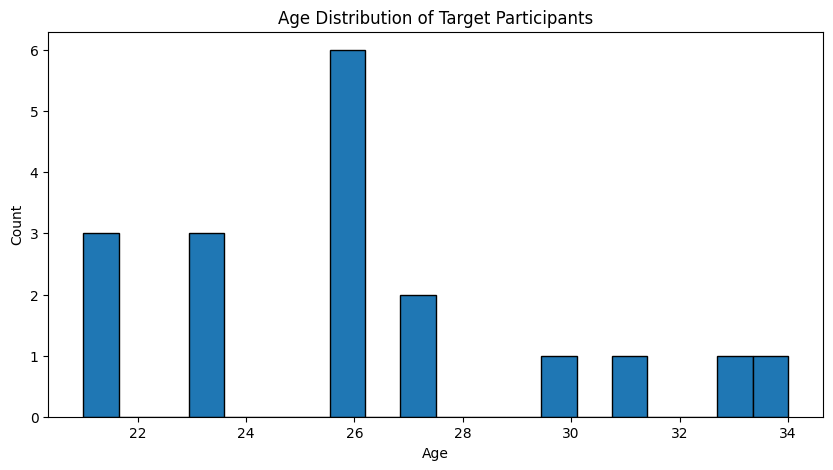

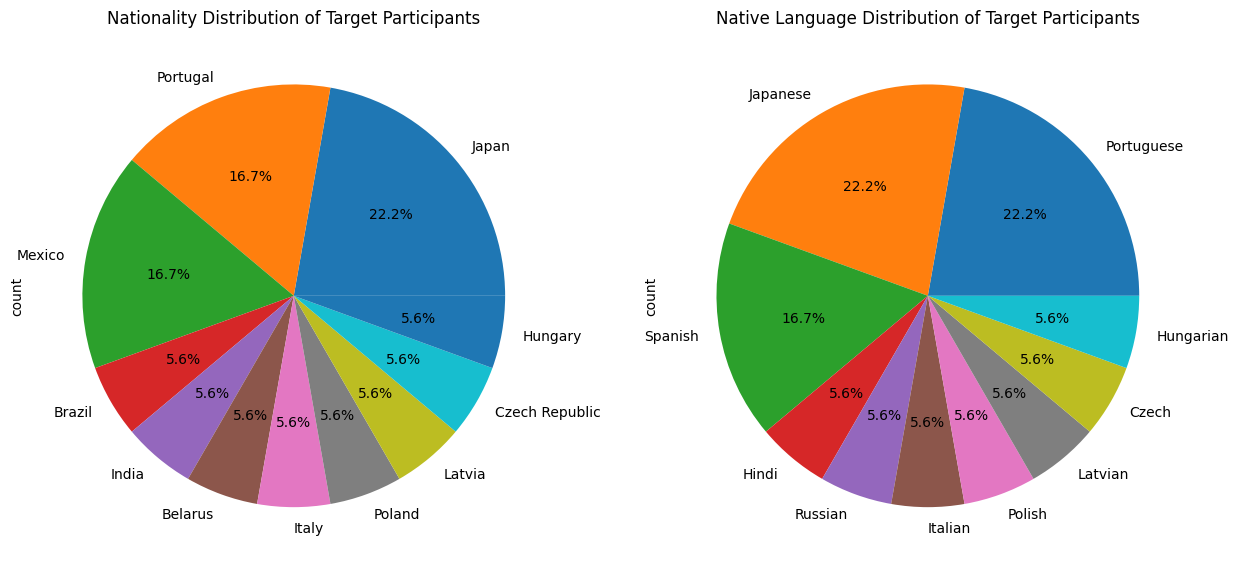


2. 対象参加者の TOEFL の正答数:
平均: 4.89
最小: 2
最大: 7


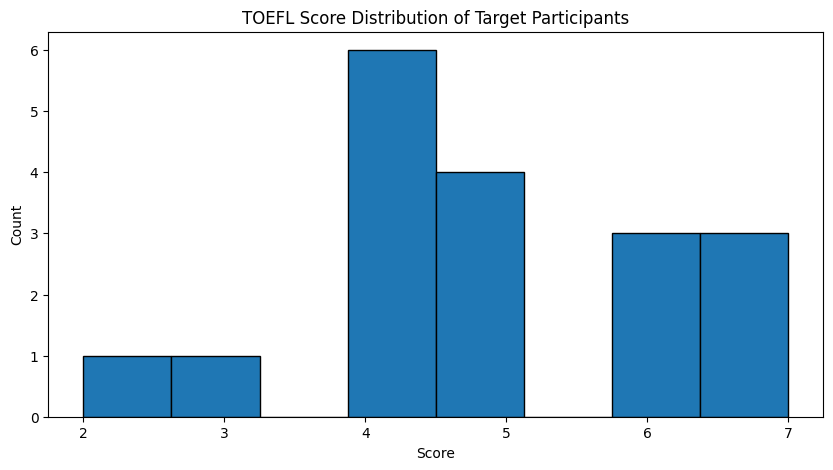


3. 対象参加者の実験動画への回答（条件別平均）:
           video_number  comprehension  engagement  readability  num_correct  \
condition                                                                      
dynamik            4.40           0.85        1.10          1.0         5.40   
keyword            5.45           2.10        2.45          3.2         4.40   
normal             5.65           1.15        1.90          1.3         5.15   

           mental_demand  physical_demand  temporal_demand  performance  \
condition                                                                 
dynamik             2.25             0.95             2.45         1.65   
keyword             3.55             1.55             2.95         3.10   
normal              2.80             1.15             2.40         2.25   

           effort  frustration  
condition                       
dynamik      2.05         1.70  
keyword      3.40         3.45  
normal       2.90         2.20  


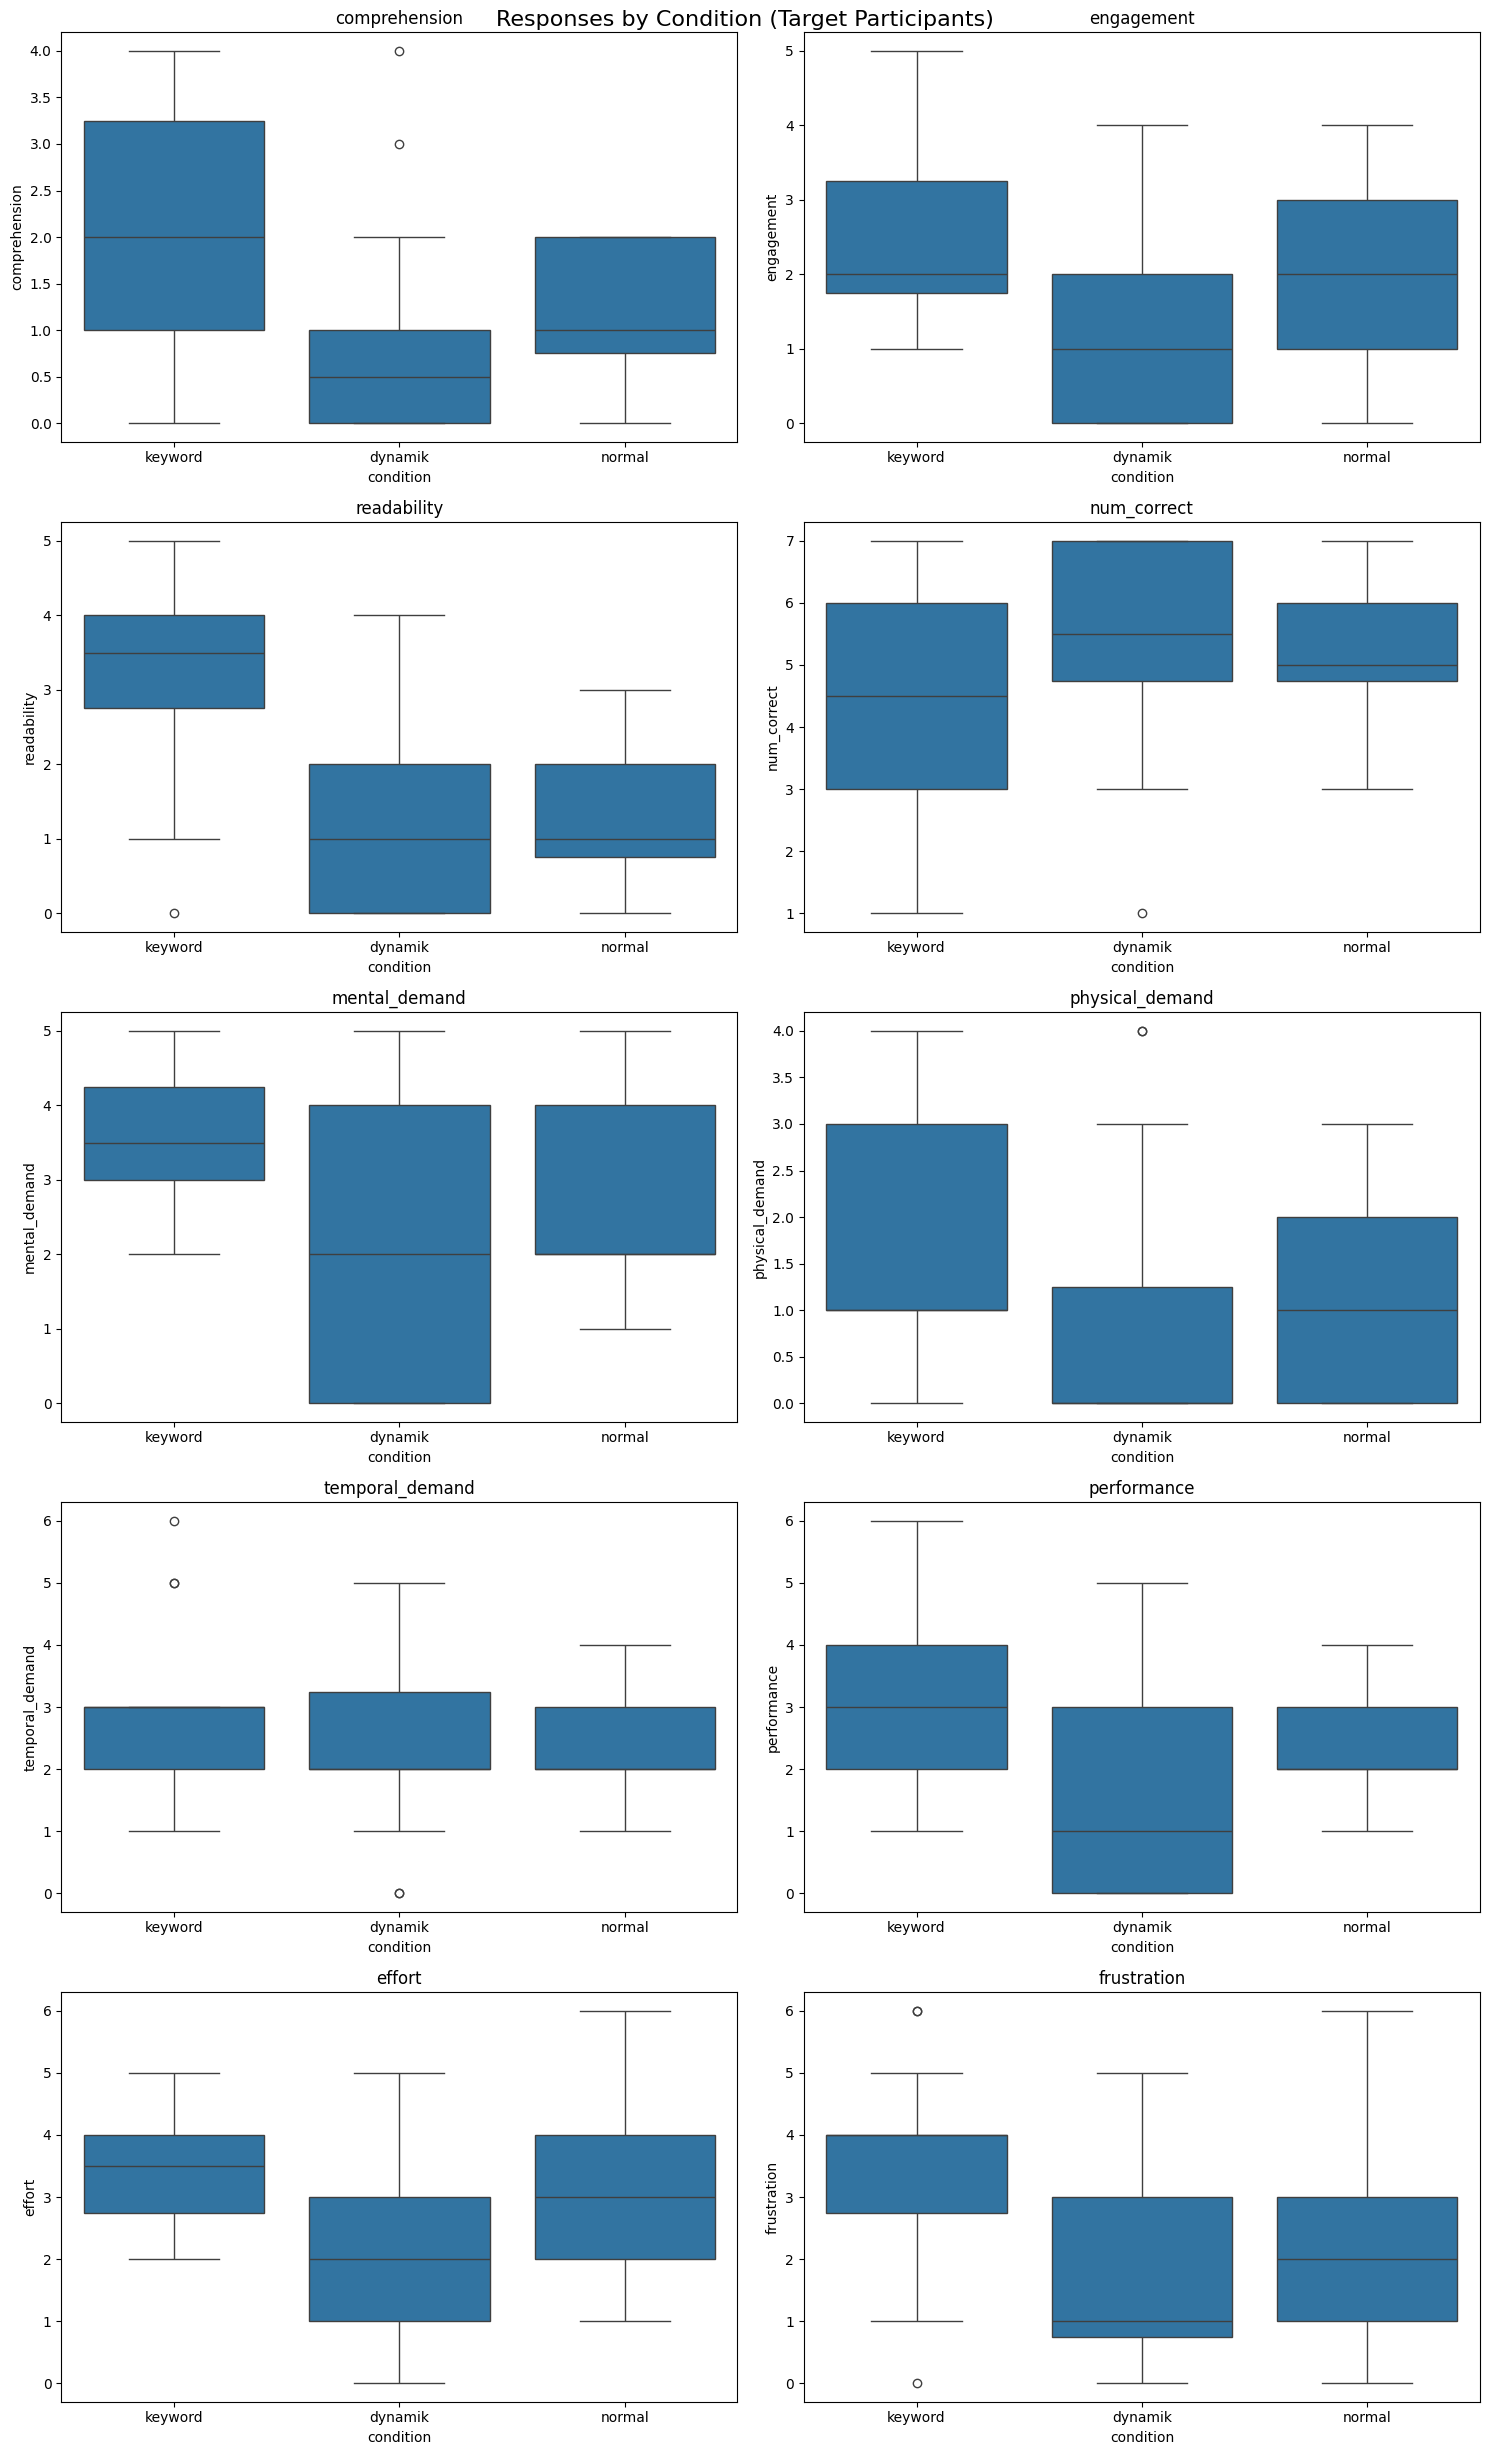


4. 対象参加者の条件の順位づけの割合:
('2', '3', '1'): 57.14%
('1', '3', '2'): 23.81%
('1', '2', '3'): 19.05%


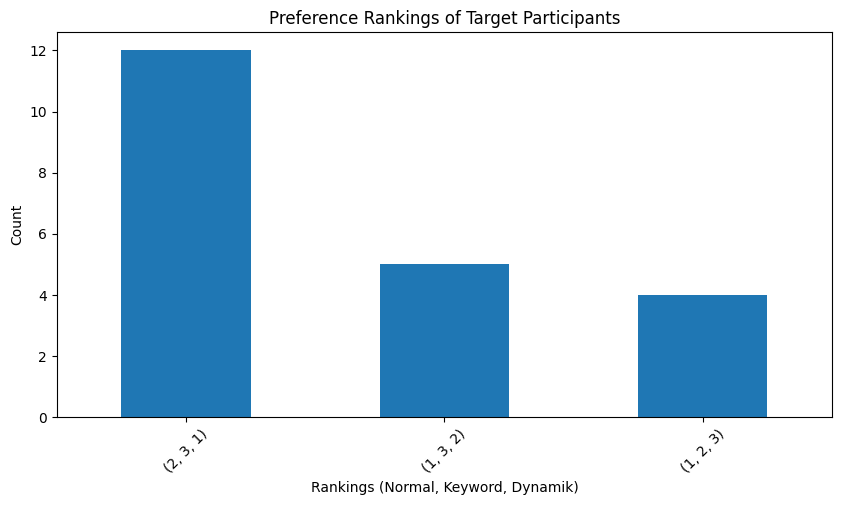


5. 対象参加者の実験全体の感想:
1. 
2. enjoyed
3. good
4. Extrange
5. nice
6. Despite the low quality (audiowise) of some of the clips, I believe that the language in all of the audio is fairly easy to comprehend.
7. 
8. amazing idea
9. 
10. It was good and I have enjoyed it.

11. 
12. 
13. good in general terms, i can practice my low skill in english despite i am a native spanish speaker it is good to have this kind of experiments in prolific, i think is a win to win exercise for all of us
14. Interesting
15. nothing special
16. good job
17. nothing special
18. the transctibe system was perfect and this helped me with understanding the audio so much.

最も頻繁に使用された単語（上位10個）:
[('the', 6), ('good', 5), ('of', 5), ('i', 5), ('in', 4), ('is', 3), ('to', 3), ('it', 3), ('enjoyed', 2), ('despite', 2)]


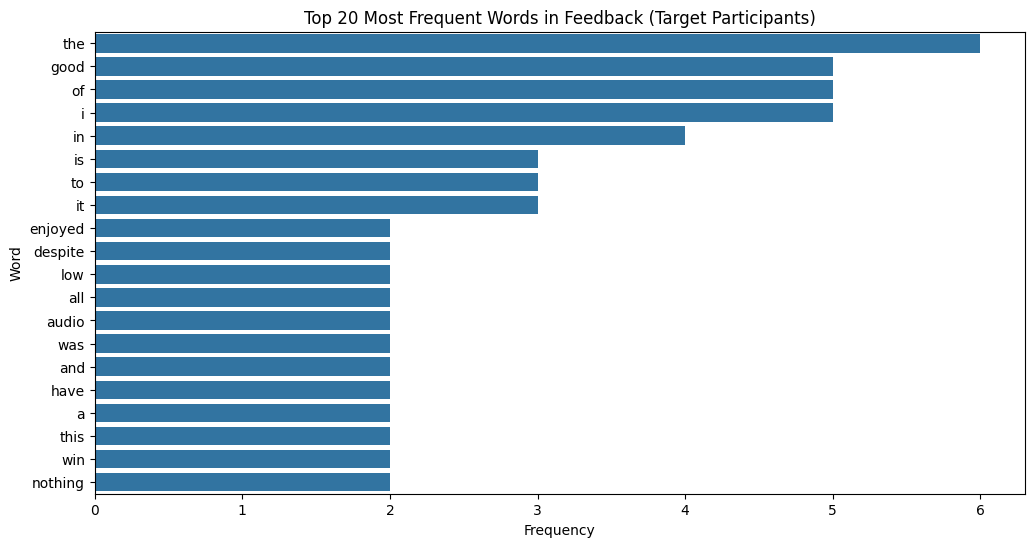

In [10]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

# データ読み込み関数
def load_json_files(pattern):
    data = []
    for file in glob.glob(pattern):
        with open(file, 'r') as f:
            data.extend(json.load(f))
    return data

# データを読み込む
data = load_json_files('/content/drive/MyDrive/山下先生ネタ/json/*.json')

# Demographic情報の取得
def get_demographics(data):
    demographics = []
    for trial in data:
        if trial.get('task') == 'demographic_survey':
            demo_data = trial['response'].copy()
            demo_data['subject_id'] = trial.get('subject_id')
            demo_data['PROLIFIC_PID'] = trial.get('PROLIFIC_PID')
            demo_data['STUDY_ID'] = trial.get('STUDY_ID')
            demo_data['SESSION_ID'] = trial.get('SESSION_ID')
            demographics.append(demo_data)
    return pd.DataFrame(demographics)

demographics = get_demographics(data)

# 非英語話者かつTOEFLスコアが7以下の参加者を特定する関数
def get_target_participants(data, demographics):
    target_ids = set()
    for trial in data:
        if trial.get('trial_index') == 6:  # TOEFLのトライアル
            subject_id = trial.get('subject_id')
            score = trial.get('num_correct')
            if score is not None and score <= 7:
                subject_data = demographics[demographics['subject_id'] == subject_id]
                if not subject_data.empty and subject_data['native_language'].values[0] != 'English':
                    target_ids.add(subject_id)
    return target_ids

# 対象となる参加者のIDを取得
target_ids = get_target_participants(data, demographics)

# 対象参加者のdemographic情報を取得
target_demographics = demographics[demographics['subject_id'].isin(target_ids)]

print("1. 対象参加者の Demographic 情報:")
print(target_demographics.describe())

# 年齢分布のヒストグラム
plt.figure(figsize=(10, 5))
plt.hist(target_demographics['age'].astype(int), bins=20, edgecolor='black')
plt.title('Age Distribution of Target Participants')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 国籍と母語の分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
target_demographics['nationality'].value_counts().plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Nationality Distribution of Target Participants')
target_demographics['native_language'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Native Language Distribution of Target Participants')
plt.show()

# 2. TOEFLの正答数（対象参加者のみ）
def get_toefl_scores(data, target_ids):
    toefl_scores = []
    for trial in data:
        if trial.get('trial_index') == 6 and trial.get('subject_id') in target_ids:
            score = trial.get('num_correct')
            if score is not None:
                toefl_scores.append(score)
    return toefl_scores

toefl_scores = get_toefl_scores(data, target_ids)

print("\n2. 対象参加者の TOEFL の正答数:")
print(f"平均: {np.mean(toefl_scores):.2f}")
print(f"最小: {np.min(toefl_scores)}")
print(f"最大: {np.max(toefl_scores)}")

# TOEFLスコアの分布
plt.figure(figsize=(10, 5))
plt.hist(toefl_scores, bins=8, edgecolor='black')
plt.title('TOEFL Score Distribution of Target Participants')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# 3. 実験動画への回答（対象参加者のみ）
def get_video_responses(data, target_ids):
    responses = []
    for i in range(0, len(data), 4):
        if data[i].get('task') == 'cnn_video' and data[i].get('subject_id') in target_ids:
            video_data = {
                'condition': data[i]['condition'],
                'video_number': data[i]['video_number'],
                'comprehension': data[i+1]['response']['comprehension'],
                'engagement': data[i+1]['response']['engagement'],
                'readability': data[i+1]['response']['readability'],
                'num_correct': data[i+2]['num_correct'],
                'mental_demand': data[i+3]['response']['mental_demand'],
                'physical_demand': data[i+3]['response']['physical_demand'],
                'temporal_demand': data[i+3]['response']['temporal_demand'],
                'performance': data[i+3]['response']['performance'],
                'effort': data[i+3]['response']['effort'],
                'frustration': data[i+3]['response']['frustration']
            }
            responses.append(video_data)
    return pd.DataFrame(responses)

video_responses = get_video_responses(data, target_ids)

print("\n3. 対象参加者の実験動画への回答（条件別平均）:")
print(video_responses.groupby('condition').mean())

# 箱ひげ図
metrics = ['comprehension', 'engagement', 'readability', 'num_correct',
           'mental_demand', 'physical_demand', 'temporal_demand', 'performance',
           'effort', 'frustration']

fig, axes = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle('Responses by Condition (Target Participants)', fontsize=16)

for i, metric in enumerate(metrics):
    sns.boxplot(x='condition', y=metric, data=video_responses, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(metric)

plt.tight_layout()
plt.show()

# 4. 条件の順位づけ（対象参加者のみ）
def get_preference_rankings(data, target_ids):
    rankings = []
    for trial in data:
        if trial.get('task') == 'subtitle_preference' and trial.get('subject_id') in target_ids:
            response = trial['response']
            ranking = (response['normal'], response['keyword'], response['dynamik'])
            rankings.append(ranking)
    return rankings

preference_rankings = get_preference_rankings(data, target_ids)
ranking_counts = pd.Series(preference_rankings).value_counts()

print("\n4. 対象参加者の条件の順位づけの割合:")
for ranking, count in ranking_counts.items():
    print(f"{ranking}: {count / len(preference_rankings):.2%}")

# 順位づけの可視化
plt.figure(figsize=(10, 5))
ranking_counts.plot(kind='bar')
plt.title('Preference Rankings of Target Participants')
plt.xlabel('Rankings (Normal, Keyword, Dynamik)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 5. 実験全体の感想（対象参加者のみ）
def get_feedback(data, target_ids):
    feedback = []
    for trial in data:
        if trial.get('task') == 'final_feedback' and trial.get('subject_id') in target_ids:
            feedback.append(trial['response']['Q0'])
    return feedback

feedback = get_feedback(data, target_ids)
print("\n5. 対象参加者の実験全体の感想:")
for i, comment in enumerate(feedback, 1):
    print(f"{i}. {comment}")

# 感想の単語頻度分析
def word_frequency(text_list):
    words = []
    for text in text_list:
        words.extend(re.findall(r'\w+', text.lower()))
    return Counter(words)

word_freq = word_frequency(feedback)
print("\n最も頻繁に使用された単語（上位10個）:")
print(word_freq.most_common(10))

# 単語頻度の可視化
plt.figure(figsize=(12, 6))
word_freq_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=word_freq_df)
plt.title('Top 20 Most Frequent Words in Feedback (Target Participants)')
plt.show()

## 英語ネイティブのみ


Language Test Scores for Native English Speakers:
TOEFL_SCORE:
  Mean: 90.00
  Median: 90.00
  Min: 90.00
  Max: 90.00
  Count: 1


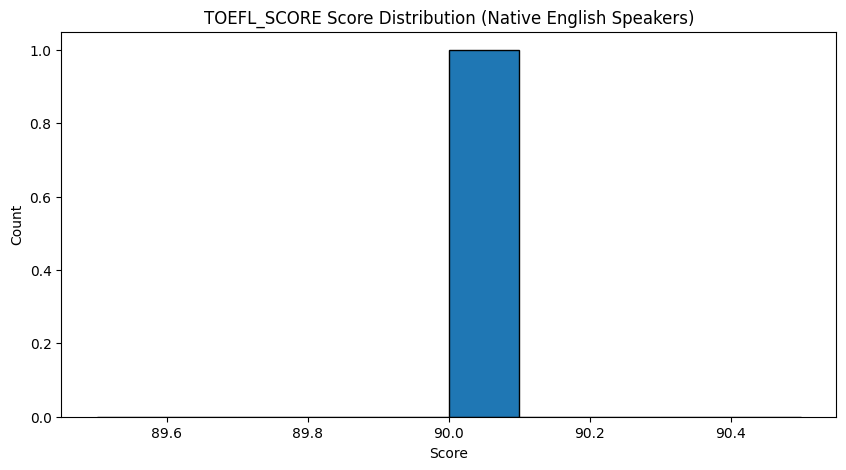

TOEIC_SCORE:
  Mean: 705.00
  Median: 705.00
  Min: 705.00
  Max: 705.00
  Count: 1


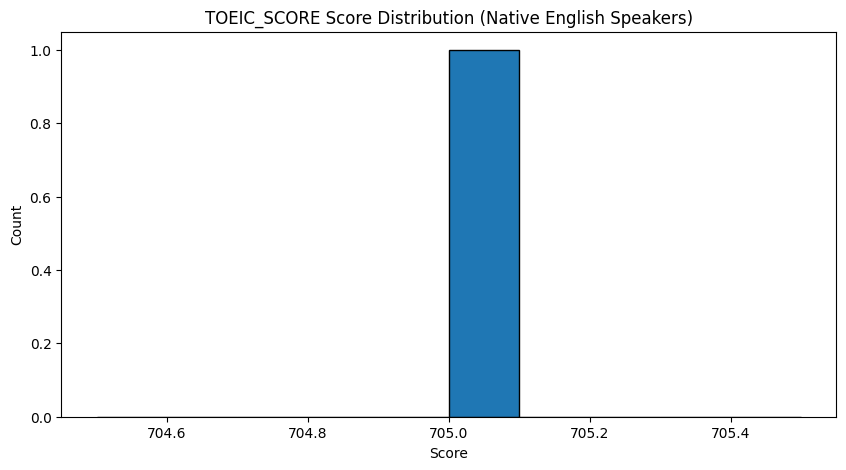

IELTS_SCORE:
  Mean: 6.50
  Median: 6.50
  Min: 6.50
  Max: 6.50
  Count: 1


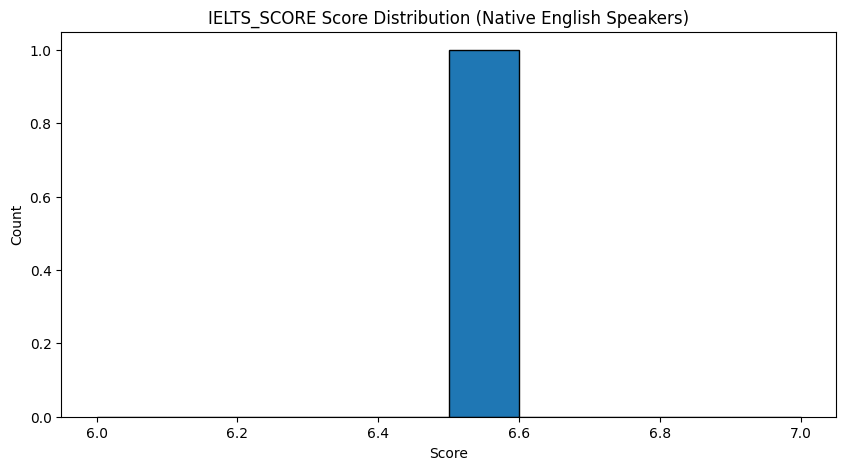

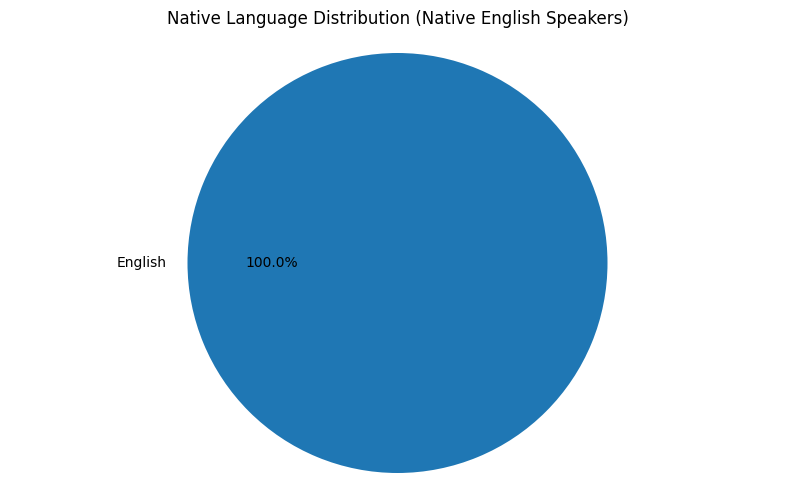


Native Language Distribution for Native English Speakers:
English: 17 (100.0%)


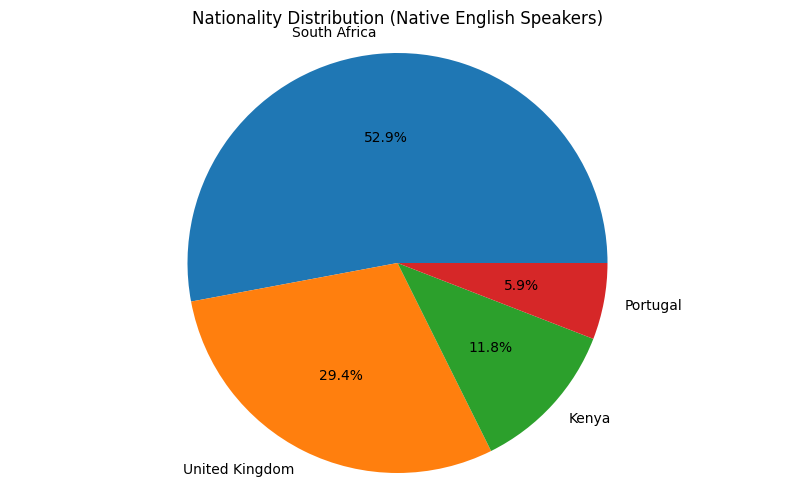


Nationality Distribution for Native English Speakers:
South Africa: 9 (52.9%)
United Kingdom: 5 (29.4%)
Kenya: 2 (11.8%)
Portugal: 1 (5.9%)


In [22]:
import numpy as np
import pandas as pd

# 英語を第一言語とする人のデータフィルタリング
native_english = demographics[demographics['native_language'] == 'English']

print("\nLanguage Test Scores for Native English Speakers:")
for test in ['toefl_score', 'toeic_score', 'ielts_score']:
    scores = native_english[test].replace('', np.nan).dropna()
    scores = pd.to_numeric(scores, errors='coerce')
    if not scores.empty:
        print(f"{test.upper()}:")
        print(f"  Mean: {scores.mean():.2f}")
        print(f"  Median: {scores.median():.2f}")
        print(f"  Min: {scores.min():.2f}")
        print(f"  Max: {scores.max():.2f}")
        print(f"  Count: {scores.count()}")

        # スコア分布のヒストグラムを描画
        plt.figure(figsize=(10, 5))
        plt.hist(scores, bins=10, edgecolor='black')
        plt.title(f'{test.upper()} Score Distribution (Native English Speakers)')
        plt.xlabel('Score')
        plt.ylabel('Count')
        plt.show()
    else:
        print(f"{test.upper()}: No valid scores")

# 英語ネイティブの言語分布
native_languages = native_english['native_language'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(native_languages.values, labels=native_languages.index, autopct='%1.1f%%')
plt.title('Native Language Distribution (Native English Speakers)')
plt.axis('equal')
plt.show()

print("\nNative Language Distribution for Native English Speakers:")
for language, count in native_languages.items():
    print(f"{language}: {count} ({count / len(native_english) * 100:.1f}%)")

# 英語ネイティブの国籍分布
native_nationalities = native_english['nationality'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(native_nationalities.values, labels=native_nationalities.index, autopct='%1.1f%%')
plt.title('Nationality Distribution (Native English Speakers)')
plt.axis('equal')
plt.show()

print("\nNationality Distribution for Native English Speakers:")
for nationality, count in native_nationalities.items():
    print(f"{nationality}: {count} ({count / len(native_english) * 100:.1f}%)")

1. 英語話者の Demographic 情報:
       gender age   nationality native_language other_language1  \
count      17  17            17              17              17   
unique      2  13             4               1               5   
top       man  28  South Africa         English                   
freq       10   3             9              17               8   

       other_language2 other_language3 toefl_score toeic_score ielts_score  \
count               17              17          17          17          17   
unique               4               3           2           2           2   
top                                                                          
freq                13              15          16          16          16   

                      subject_id              PROLIFIC_PID  \
count                         17                        17   
unique                        17                        17   
top     6691d1c25524897b604ba5e5  6691d1c25524897b604ba5e5   


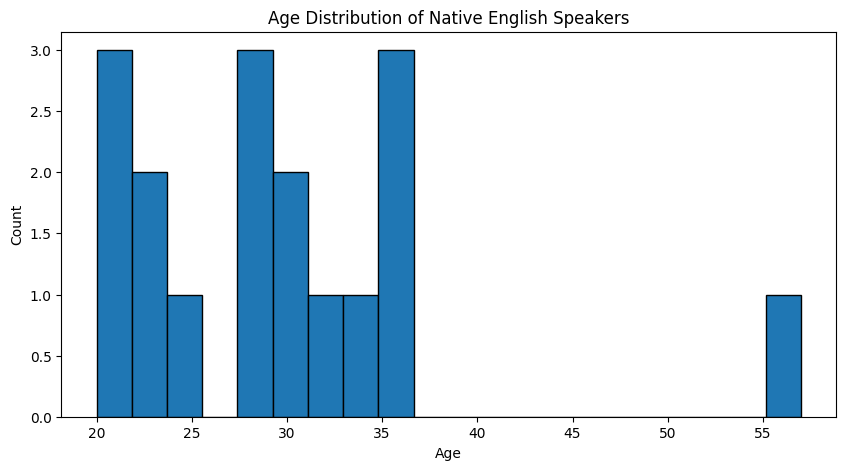

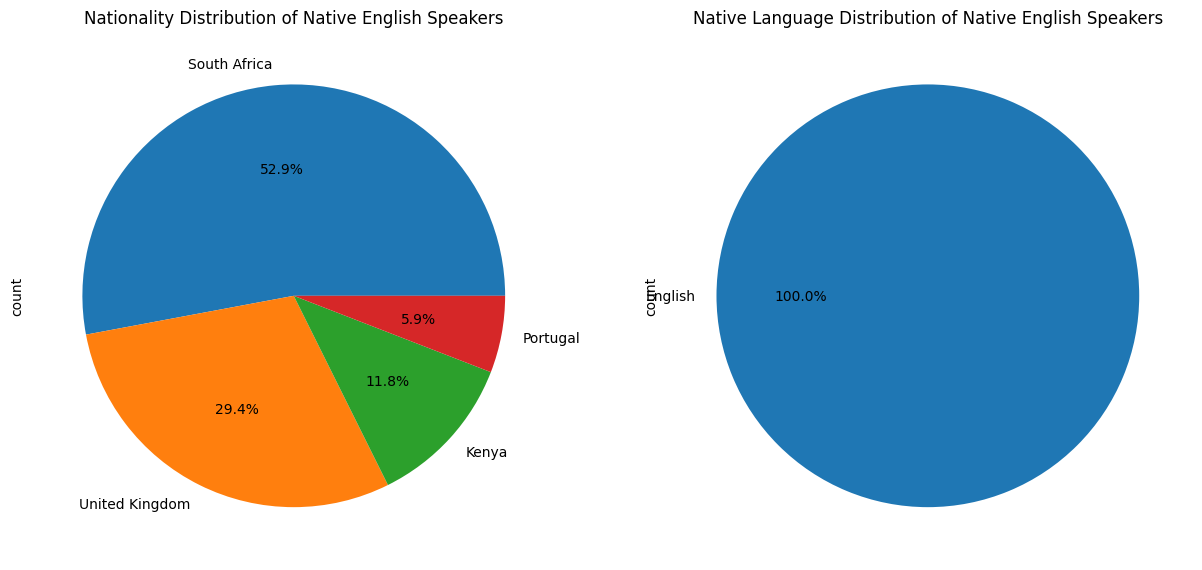

Subject 6697e7c43843491550b0b41b not in native_ids
Subject 656d44cb7a5c6f820a5a1bff not in native_ids
Subject 615362d24a07d7207bfe714d not in native_ids
Subject 663a57e3306a58cfc492d2ff not in native_ids
Subject d4zy36cjhq not in native_ids
Subject 661bfaacdb7c66838bc16244 not in native_ids
Subject 1sxqncm1k2 not in native_ids
Subject 5a3e5fb0b77a5000014a755a not in native_ids
Subject 3bjmhsly85 not in native_ids
Subject 5d1e501e755c59001709a785 not in native_ids
Subject 5dada613823b7d0016484453 not in native_ids
Subject 5cb49ebeaa462b000173d4ce not in native_ids
Subject 5c70232d78263500015658a6 not in native_ids
Subject 5e8a66381afb2c714058b57b not in native_ids
Subject 5e8caee6b47439057c61db9f not in native_ids
Subject 5e9bd025eb6b380e1d66d04c not in native_ids
Subject 5f09d989eff16b266fba44c0 not in native_ids
Subject 5f54cdbcd2fd0a8484ef4645 not in native_ids
Subject 5fa1e1267a3f7037fd2bdf13 not in native_ids
Subject 5f6cff47dd1c3b14e7af9614 not in native_ids
Subject 5f45282b851514

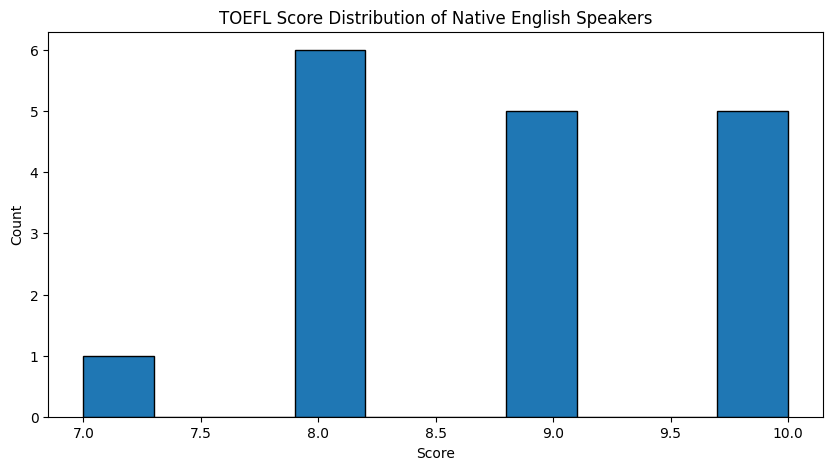


3. 英語話者の実験動画への回答（条件別平均）:
           video_number  comprehension  engagement  readability  num_correct  \
condition                                                                      
dynamik             5.0         1.0000      1.0000       1.5625       6.1250   
keyword             5.5         0.8125      1.3125       1.8125       5.0625   
normal              5.0         0.8750      1.0625       1.1875       4.8125   

           mental_demand  physical_demand  temporal_demand  performance  \
condition                                                                 
dynamik           2.5625            0.500            2.750       1.8125   
keyword           3.0000            0.875            2.875       2.1875   
normal            2.2500            0.750            2.250       1.8750   

           effort  frustration  
condition                       
dynamik    2.7500       1.5000  
keyword    2.5625       1.8125  
normal     2.9375       1.2500  


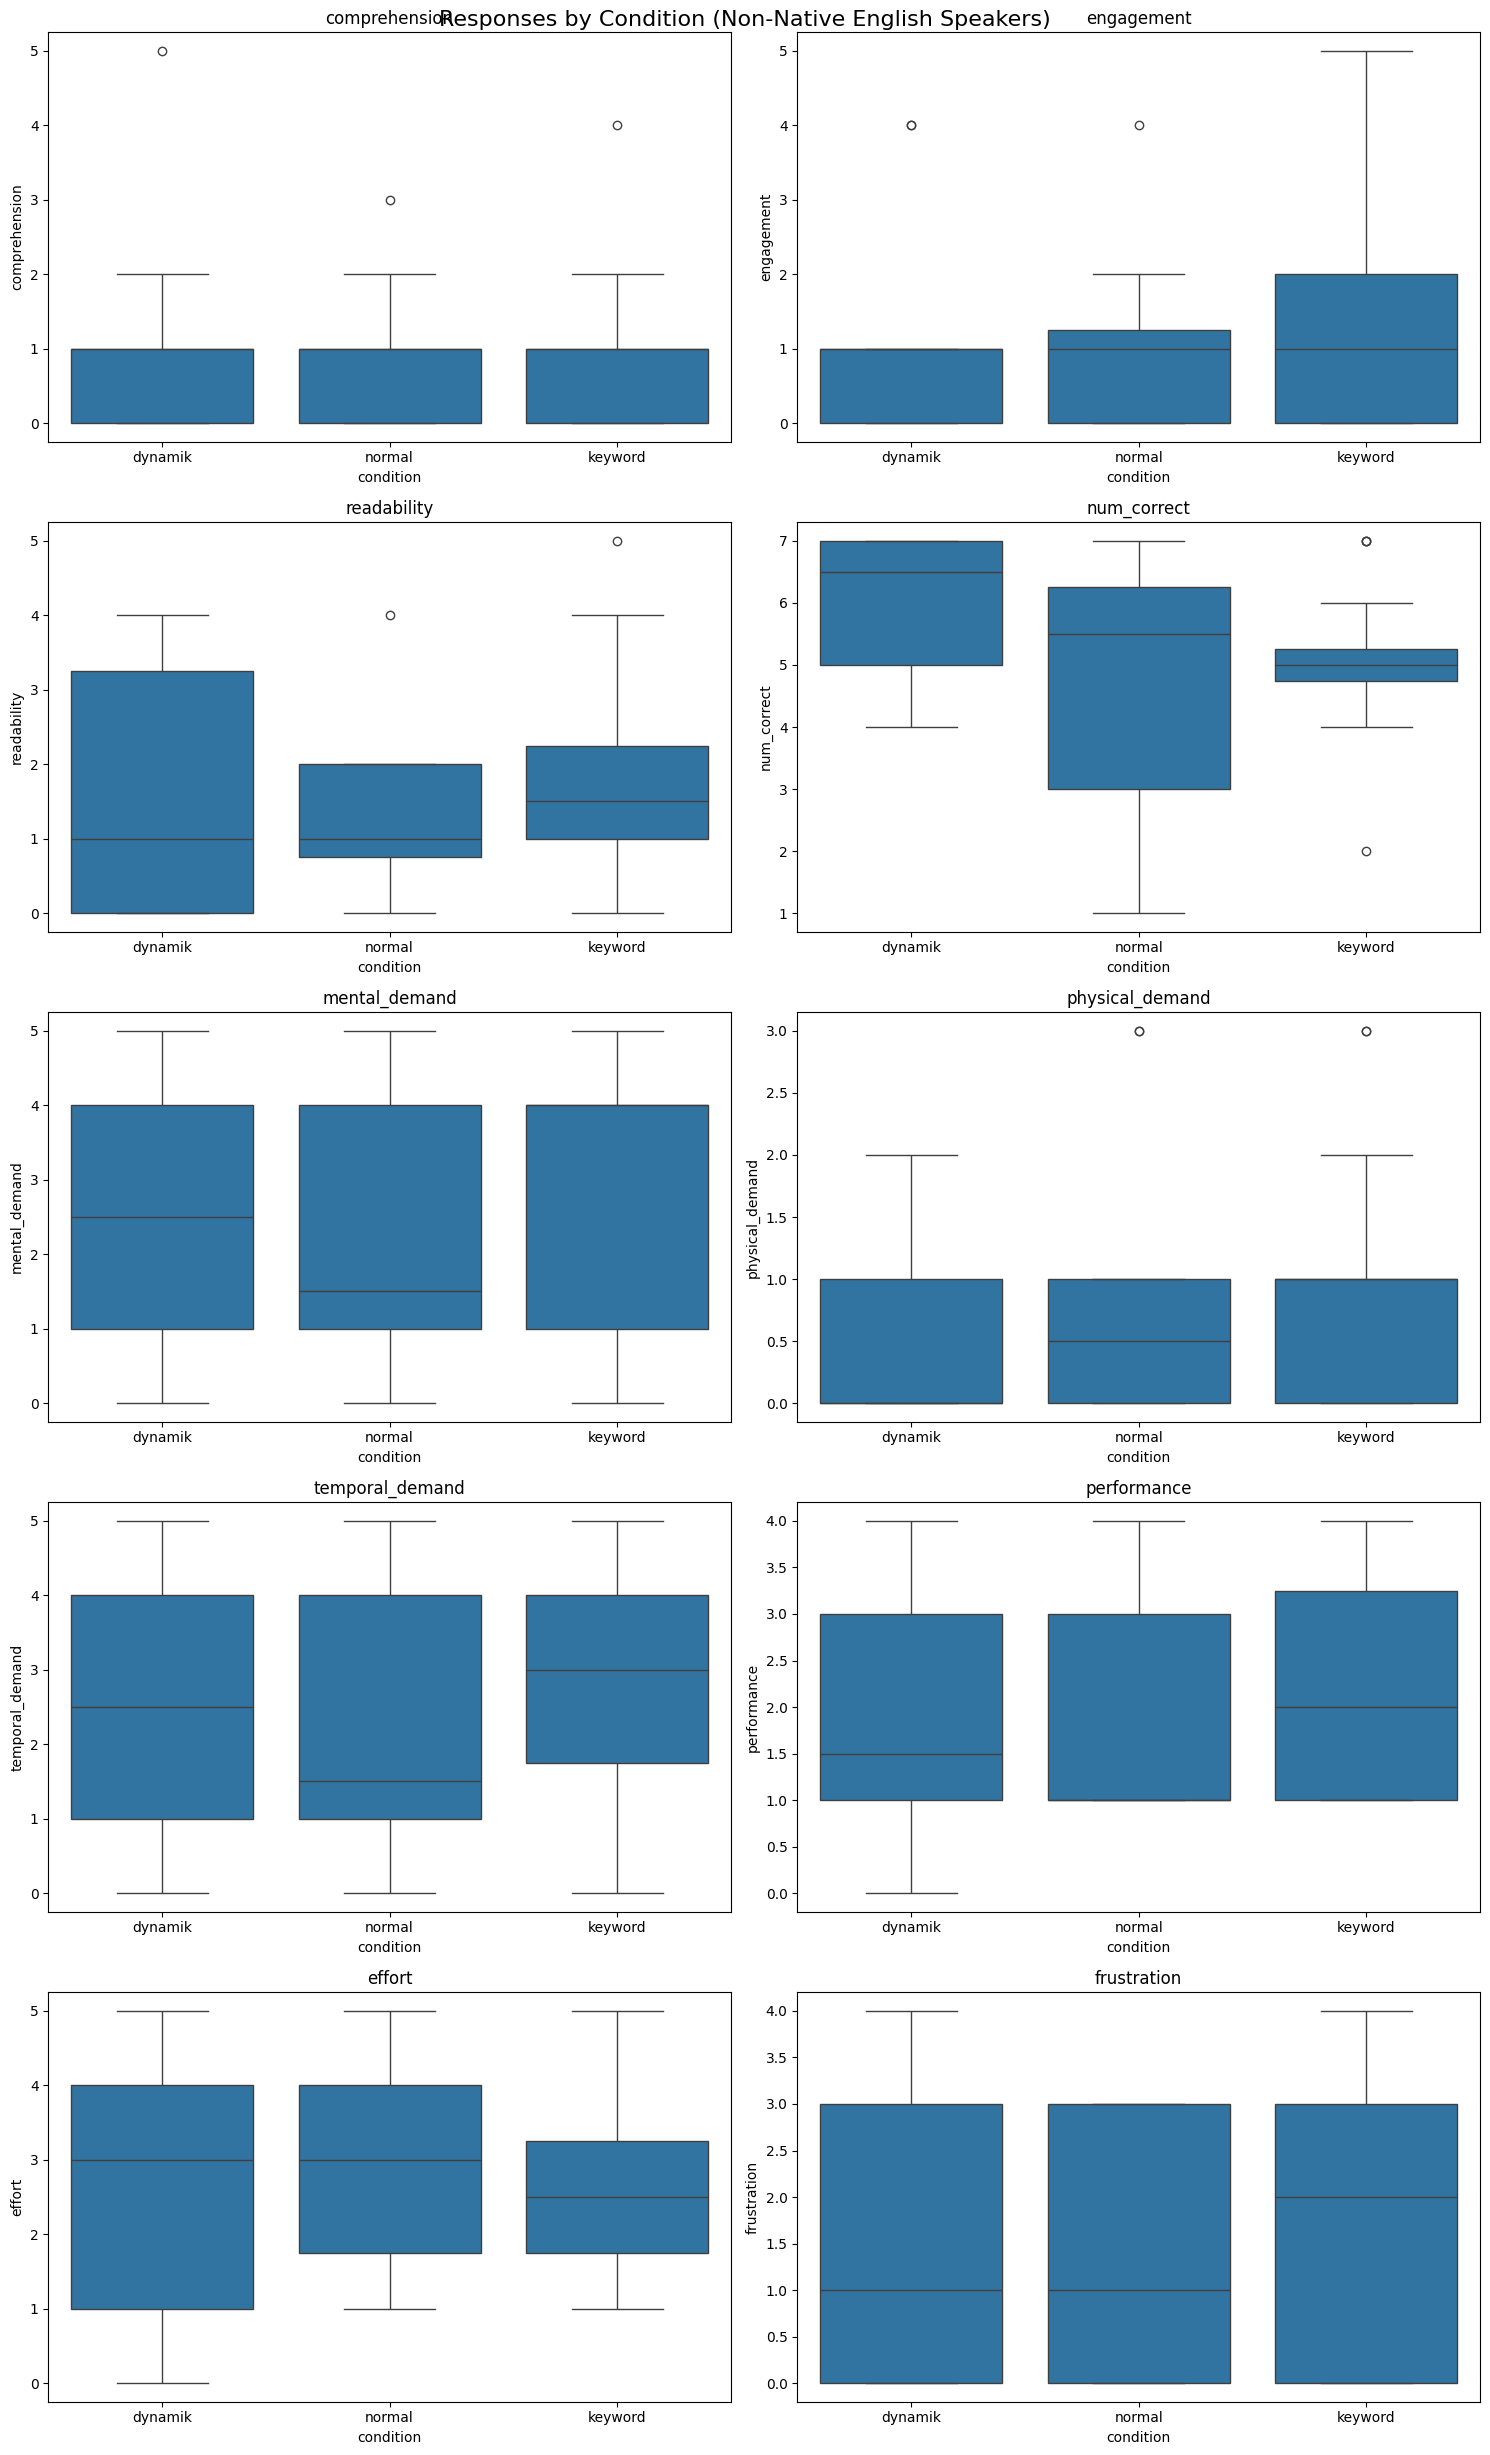


4. 英語話者の条件の順位づけの割合:
('1', '3', '2'): 29.41%
('2', '3', '1'): 23.53%
('1', '2', '3'): 17.65%
('2', '1', '3'): 11.76%
('3', '2', '1'): 11.76%
('3', '1', '2'): 5.88%


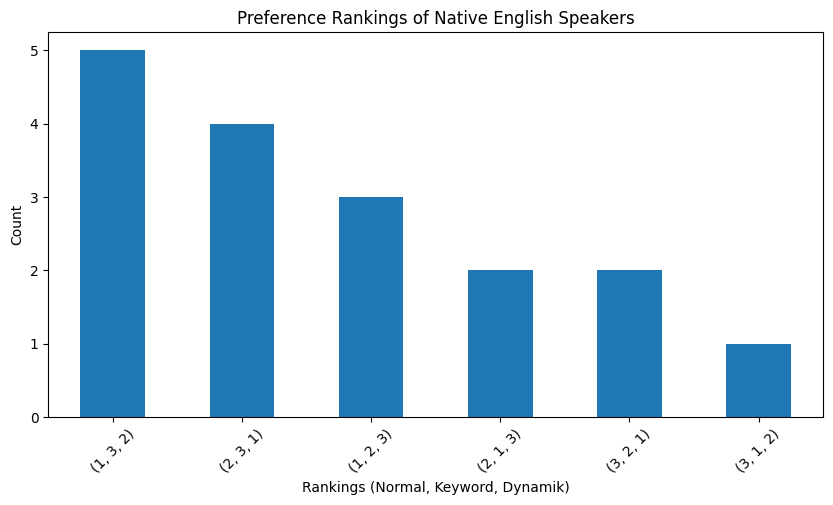


5. 非英語話者の実験全体の感想:
1. 
2. It was really easy to do and it was mentally stimulating 
3. 
4. 
5. interesting. I found the news artciles very interesting
6. enjoyed it, made me think well and concentrate.
7. It was very interesting and enjoyable. 
8. 
9. Cool, I enjoyed it.
10. I enjoyed it. Some of the stories were engaging and it was interesting to see what I remembered from the news stories
11. Although its a bit tedious, it really pushes one to concentrate so that they understand what is being presented.
12. it went well
13. The experiment was delightful and gave insights on types of subtitles used in videos. Which I was not aware of.
14. It was a good experiment , i was able to practice my listening skills and my ability to make notes . I was also able to practise my reading skills of different sizes of words
15. The experiment is easy and straight forward
16. well conducted, clips easy to hear and i understood what was expected of me
17. It helped to bring to the forefront the diffe

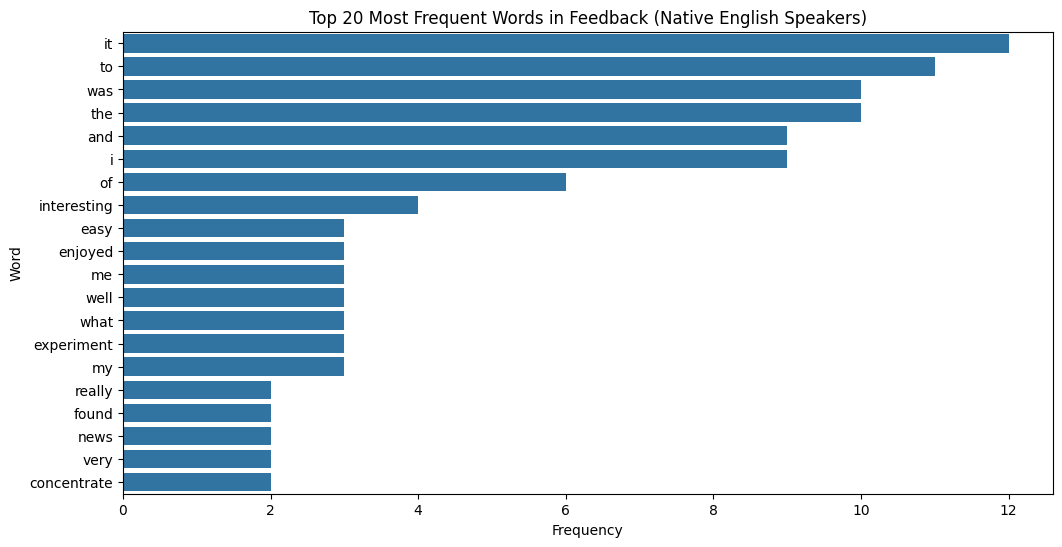

In [24]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

# データ読み込み関数（前回と同じ）
def load_json_files(pattern):
    data = []
    for file in glob.glob(pattern):
        with open(file, 'r') as f:
            data.extend(json.load(f))
    return data

# データを読み込む
data = load_json_files('/content/drive/MyDrive/山下先生ネタ/json/*.json')

# Demographic情報の取得
def get_demographics(data):
    demographics = []
    for trial in data:
        if trial.get('task') == 'demographic_survey':
            demo_data = trial['response'].copy()  # responseの内容をコピー
            # 追加の情報を含める
            demo_data['subject_id'] = trial.get('subject_id')
            demo_data['PROLIFIC_PID'] = trial.get('PROLIFIC_PID')
            demo_data['STUDY_ID'] = trial.get('STUDY_ID')
            demo_data['SESSION_ID'] = trial.get('SESSION_ID')
            demographics.append(demo_data)
    return pd.DataFrame(demographics)
demographics = get_demographics(data)

# 英語話者のデータのみをフィルタリング
native_english = demographics[demographics['native_language'] == 'English']

# native_ids を作成
native_ids = set(native_english['subject_id'])

print("1. 英語話者の Demographic 情報:")
print(native_english.describe())

# 年齢分布のヒストグラム
plt.figure(figsize=(10, 5))
plt.hist(native_english['age'].astype(int), bins=20, edgecolor='black')
plt.title('Age Distribution of Native English Speakers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 国籍と母語の分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
native_english['nationality'].value_counts().plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Nationality Distribution of Native English Speakers')
native_english['native_language'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Native Language Distribution of Native English Speakers')
plt.show()

# 2. TOEFLの正答数（英語話者のみ）
def get_toefl_scores(data, native_ids):
    toefl_scores = []
    for trial in data:
        if trial.get('trial_index') == 6:
            if trial.get('subject_id') in native_ids:
                score = trial.get('num_correct')
                if score is not None:
                    toefl_scores.append(score)
                else:
                    print(f"Warning: 'num_correct' not found for subject {trial.get('subject_id')}")
            else:
                print(f"Subject {trial.get('subject_id')} not in native_ids")

    if not toefl_scores:
        print("No TOEFL scores found for native speakers")

    return toefl_scores

toefl_scores = get_toefl_scores(data, native_ids)

if toefl_scores:
    print("\n2. 英語話者の TOEFL の正答数:")
    print(f"平均: {np.mean(toefl_scores):.2f}")
    print(f"最小: {np.min(toefl_scores)}")
    print(f"最大: {np.max(toefl_scores)}")
else:
    print("No valid TOEFL scores found for analysis")

# TOEFLスコアの分布
plt.figure(figsize=(10, 5))
plt.hist(toefl_scores, bins=10, edgecolor='black')
plt.title('TOEFL Score Distribution of Native English Speakers')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# 3. 実験動画への回答（英語話者のみ）
def get_video_responses(data, native_ids):
    responses = []
    for i in range(0, len(data), 4):
        if data[i].get('task') == 'cnn_video' and data[i].get('subject_id') in native_ids:
            video_data = {
                'condition': data[i]['condition'],
                'video_number': data[i]['video_number'],
                'comprehension': data[i+1]['response']['comprehension'],
                'engagement': data[i+1]['response']['engagement'],
                'readability': data[i+1]['response']['readability'],
                'num_correct': data[i+2]['num_correct'],
                'mental_demand': data[i+3]['response']['mental_demand'],
                'physical_demand': data[i+3]['response']['physical_demand'],
                'temporal_demand': data[i+3]['response']['temporal_demand'],
                'performance': data[i+3]['response']['performance'],
                'effort': data[i+3]['response']['effort'],
                'frustration': data[i+3]['response']['frustration']
            }
            responses.append(video_data)
    return pd.DataFrame(responses)

video_responses = get_video_responses(data, native_ids)

print("\n3. 英語話者の実験動画への回答（条件別平均）:")
print(video_responses.groupby('condition').mean())

# 箱ひげ図
metrics = ['comprehension', 'engagement', 'readability', 'num_correct',
           'mental_demand', 'physical_demand', 'temporal_demand', 'performance',
           'effort', 'frustration']

fig, axes = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle('Responses by Condition (Non-Native English Speakers)', fontsize=16)

for i, metric in enumerate(metrics):
    sns.boxplot(x='condition', y=metric, data=video_responses, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(metric)

plt.tight_layout()
plt.show()

# 4. 条件の順位づけ（英語話者のみ）
def get_preference_rankings(data, native_ids):
    rankings = []
    for trial in data:
        if trial.get('task') == 'subtitle_preference' and trial.get('subject_id') in native_ids:
            response = trial['response']
            ranking = (response['normal'], response['keyword'], response['dynamik'])
            rankings.append(ranking)
    return rankings

preference_rankings = get_preference_rankings(data, native_ids)
ranking_counts = pd.Series(preference_rankings).value_counts()

print("\n4. 英語話者の条件の順位づけの割合:")
for ranking, count in ranking_counts.items():
    print(f"{ranking}: {count / len(preference_rankings):.2%}")

# 順位づけの可視化
plt.figure(figsize=(10, 5))
ranking_counts.plot(kind='bar')
plt.title('Preference Rankings of Native English Speakers')
plt.xlabel('Rankings (Normal, Keyword, Dynamik)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 5. 実験全体の感想（英語話者のみ）
def get_feedback(data, native_ids):
    feedback = []
    for trial in data:
        if trial.get('task') == 'final_feedback' and trial.get('subject_id') in native_ids:
            feedback.append(trial['response']['Q0'])
    return feedback

feedback = get_feedback(data, native_ids)
print("\n5. 非英語話者の実験全体の感想:")
for i, comment in enumerate(feedback, 1):
    print(f"{i}. {comment}")

# 感想の単語頻度分析
def word_frequency(text_list):
    words = []
    for text in text_list:
        words.extend(re.findall(r'\w+', text.lower()))
    return Counter(words)

word_freq = word_frequency(feedback)
print("\n最も頻繁に使用された単語（上位10個）:")
print(word_freq.most_common(10))

# 単語頻度の可視化
plt.figure(figsize=(12, 6))
word_freq_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=word_freq_df)
plt.title('Top 20 Most Frequent Words in Feedback (Native English Speakers)')
plt.show()

# 検定

In [8]:
from scipy import stats
from scipy.stats import ks_2samp, mannwhitneyu
import numpy as np
import pandas as pd
from itertools import combinations

def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_se

def perform_tests(data, metrics):
    conditions = ['normal', 'keyword', 'dynamik']
    results = []

    for metric in metrics:
        print(f"\n分析: {metric}")
        for cond1, cond2 in combinations(conditions, 2):
            group1 = data[data['condition'] == cond1][metric]
            group2 = data[data['condition'] == cond2][metric]

            # Kolmogorov-Smirnov test
            ks_statistic, ks_pvalue = ks_2samp(group1, group2)
            print(f"{cond1} vs {cond2} - Kolmogorov-Smirnov test:")
            print(f"  統計量: {ks_statistic:.4f}, p値: {ks_pvalue:.4f}")

            # Mann-Whitney U test
            mw_statistic, mw_pvalue = mannwhitneyu(group1, group2, alternative='two-sided')
            print(f"{cond1} vs {cond2} - Mann-Whitney U test:")
            print(f"  統計量: {mw_statistic:.4f}, p値: {mw_pvalue:.4f}")

            # Cohen's d
            effect_size = cohens_d(group1, group2)
            print(f"{cond1} vs {cond2} - Cohen's d:")
            print(f"  効果量: {effect_size:.4f}")

            results.append({
                'Metric': metric,
                'Comparison': f"{cond1} vs {cond2}",
                'KS_Statistic': ks_statistic,
                'KS_pvalue': ks_pvalue,
                'MW_Statistic': mw_statistic,
                'MW_pvalue': mw_pvalue,
                'Cohens_d': effect_size
            })

    return pd.DataFrame(results)

# NASA-TLX metrics
nasa_tlx_metrics = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']

# Video survey metrics
video_survey_metrics = ['comprehension', 'engagement', 'readability']

# Perform tests for NASA-TLX metrics
nasa_tlx_results = perform_tests(video_responses, nasa_tlx_metrics)

# Perform tests for video survey metrics
video_survey_results = perform_tests(video_responses, video_survey_metrics)

# Display results
print("\nNASA-TLX Results:")
print(nasa_tlx_results)

print("\nVideo Survey Results:")
print(video_survey_results)

# Save results to CSV
nasa_tlx_results.to_csv('nasa_tlx_test_results.csv', index=False)
video_survey_results.to_csv('video_survey_test_results.csv', index=False)


分析: mental_demand
normal vs keyword - Kolmogorov-Smirnov test:
  統計量: 0.1522, p値: 0.6669
normal vs keyword - Mann-Whitney U test:
  統計量: 899.0000, p値: 0.2055
normal vs keyword - Cohen's d:
  効果量: -0.2699
normal vs dynamik - Kolmogorov-Smirnov test:
  統計量: 0.1304, p値: 0.8345
normal vs dynamik - Mann-Whitney U test:
  統計量: 985.5000, p値: 0.5668
normal vs dynamik - Cohen's d:
  効果量: -0.0409
keyword vs dynamik - Kolmogorov-Smirnov test:
  統計量: 0.1522, p値: 0.6669
keyword vs dynamik - Mann-Whitney U test:
  統計量: 1124.0000, p値: 0.6016
keyword vs dynamik - Cohen's d:
  効果量: 0.1976

分析: physical_demand
normal vs keyword - Kolmogorov-Smirnov test:
  統計量: 0.1957, p値: 0.3450
normal vs keyword - Mann-Whitney U test:
  統計量: 820.5000, p値: 0.0563
normal vs keyword - Cohen's d:
  効果量: -0.3954
normal vs dynamik - Kolmogorov-Smirnov test:
  統計量: 0.0870, p値: 0.9959
normal vs dynamik - Mann-Whitney U test:
  統計量: 998.5000, p値: 0.6325
normal vs dynamik - Cohen's d:
  効果量: -0.1580
keyword vs dynamik - Kolmog